In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


plt.rc('font',size=14)
sns.set(style='white')
sns.set(style='whitegrid',color_codes=True)
#To enable plotting graphs in Jupyter notebook


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor)
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.ensemble import VotingRegressor

from scipy import stats
from scipy.stats import zscore
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.utils import resample

1. Data processing

In [2]:
df=pd.read_csv('Loan_data.csv', low_memory=False)

In [3]:
df.shape

(42536, 151)

In [4]:
summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
summary['Nulls'] = pd.DataFrame(df.isnull().any())
summary['Sum_of_nulls'] = pd.DataFrame(df.isnull().sum())
summary['Per_of_nulls'] = round((df.apply(pd.isnull).mean()*100),2)
summary.Dtype = summary.Dtype.astype(str)
print(summary)

                         Dtype  Nulls  Sum_of_nulls  Per_of_nulls
id                      object  False             0          0.00
member_id              float64   True         42536        100.00
loan_amnt              float64   True             1          0.00
funded_amnt            float64   True             1          0.00
funded_amnt_inv        float64   True             1          0.00
...                        ...    ...           ...           ...
settlement_status       object   True         42376         99.62
settlement_date         object   True         42376         99.62
settlement_amount      float64   True         42376         99.62
settlement_percentage  float64   True         42376         99.62
settlement_term        float64   True         42376         99.62

[151 rows x 4 columns]


Usuwam kolumny i rzędy, w których brakuje ponad 90% danych

In [5]:
threshold = 0.9
df = df[df.columns[df.isnull().mean() < threshold]]
df = df.loc[df.isnull().mean(axis=1) < threshold]

Usuwam kolumnę id

In [6]:
df.drop(['id'], axis=1, inplace=True)

In [7]:
df.shape

(42535, 60)

Zostało 60 kolumn.
Będę je analizować podglądając kawałkami tabeli.

In [8]:
df.iloc[:5, 0:15]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid


In [9]:
df.isnull().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                      2626
emp_length                     1112
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
desc                          13293
purpose                           0
title                            13
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
fico_range_low                    0
fico_range_high                   0
inq_last_6mths              

int_rate - brak wartości pustych, zmieniam z object na float

In [10]:
df.int_rate

0         10.65%
1         15.27%
2         15.96%
3         13.49%
4         12.69%
          ...   
42531     10.28%
42532      9.64%
42533      9.33%
42534      8.38%
42535      7.75%
Name: int_rate, Length: 42535, dtype: object

In [11]:
df['int_rate'] = df['int_rate'].str.replace('%', ' ').astype('float')
df.int_rate

0        10.65
1        15.27
2        15.96
3        13.49
4        12.69
         ...  
42531    10.28
42532     9.64
42533     9.33
42534     8.38
42535     7.75
Name: int_rate, Length: 42535, dtype: float64

emp_title 

kolumna ma 2626 wartości pustych, a opisy są bardzo zróżnicowane - jest ich 30658, więc kolumnę usuwam 

In [12]:
df.emp_title.value_counts()

US Army                             139
Bank of America                     115
IBM                                  72
Kaiser Permanente                    61
AT&T                                 61
                                   ... 
Japond Restaurant LLC                 1
Portamedic                            1
Newport News Shipbuilding             1
Northeastern Illinois University      1
Brinks Global services                1
Name: emp_title, Length: 30658, dtype: int64

In [13]:
df.drop(['emp_title'], axis=1, inplace=True)

emp_length

brakujące wartości uzupełniam wartością najczęściej występującą

In [14]:
df.emp_length.value_counts()

10+ years    9369
< 1 year     5062
2 years      4743
3 years      4364
4 years      3649
1 year       3595
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
Name: emp_length, dtype: int64

In [15]:
df['emp_length'] = df['emp_length'].str.rstrip('years')

In [16]:
df['emp_length'] = df['emp_length'].str.replace('+', '')
df['emp_length'] = df['emp_length'].str.replace('< 1', '0').astype('float')

In [17]:
df['emp_length'].fillna(df.emp_length.mode()[0], inplace=True)

In [18]:
df.emp_length.value_counts()

10.0    10481
0.0      5062
2.0      4743
3.0      4364
4.0      3649
1.0      3595
5.0      3458
6.0      2375
7.0      1875
8.0      1592
9.0      1341
Name: emp_length, dtype: int64

annual_inc

brakuje czterech pozycji - uzupełniam wartością najczęściej występującą

In [19]:
df.annual_inc.isnull().sum()

4

In [20]:
df.annual_inc.fillna(df.annual_inc.mode()[0], inplace=True)
df.annual_inc

0         24000.0
1         30000.0
2         12252.0
3         49200.0
4         80000.0
           ...   
42531    180000.0
42532     12000.0
42533    110000.0
42534     60000.0
42535     70000.0
Name: annual_inc, Length: 42535, dtype: float64

In [21]:
df.iloc[:5, 13:28]

,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq
0,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN
1,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN
2,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN
3,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,35.0
4,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,38.0


Usuwam niepotrzebne kolumny z danymi tekstowymi, które są bardzo różnorodne, albo jednakowe

In [22]:
df.pymnt_plan.value_counts()

n    42535
Name: pymnt_plan, dtype: int64

In [23]:
df.desc.value_counts()

In [24]:
df.drop(['url', 'pymnt_plan', 'desc'], axis=1, inplace=True)

purpose, title

In [25]:
df.purpose.value_counts()

debt_consolidation    19776
credit_card            5477
other                  4425
home_improvement       3199
major_purchase         2311
small_business         1992
car                    1615
wedding                1004
medical                 753
moving                  629
house                   426
educational             422
vacation                400
renewable_energy        106
Name: purpose, dtype: int64

In [26]:
df.title.value_counts()

Debt Consolidation                       2259
Debt Consolidation Loan                  1760
Personal Loan                             708
Consolidation                             547
debt consolidation                        532
                                         ... 
Tarrick                                     1
shauns                                      1
backontrack2010                             1
Pay off personal loan and pay off CC        1
used car new engine                         1
Name: title, Length: 21264, dtype: int64

purpose wygląda na bardziej wiarygodne, jest mniej różnorodne, kolumnę title usuwam, a także zip_code

In [27]:
df.drop(['zip_code', 'title'], axis=1, inplace=True)

delinq_2yrs - tylko 29 brakujących, uzupełniam wartością najczęściej występującą

In [28]:
df.delinq_2yrs.value_counts()

0.0     37771
1.0      3595
2.0       771
3.0       244
4.0        72
5.0        27
6.0        13
7.0         6
8.0         3
11.0        2
13.0        1
9.0         1
Name: delinq_2yrs, dtype: int64

In [29]:
df.delinq_2yrs.isnull().sum()

29

In [30]:
df.delinq_2yrs.mode()

0    0.0
dtype: float64

In [31]:
df.delinq_2yrs.median()

0.0

In [32]:
df.delinq_2yrs.fillna(df.delinq_2yrs.mode()[0], inplace=True)

earliest_cr_line - uzupełniam brakujące wartości i zmieniam format danych

In [33]:
df.earliest_cr_line.value_counts()

Oct-1999    393
Nov-1998    390
Oct-2000    370
Dec-1998    366
Dec-1997    348
           ... 
Oct-1974      1
Jan-1946      1
Dec-1965      1
Feb-1966      1
Nov-1968      1
Name: earliest_cr_line, Length: 530, dtype: int64

In [34]:
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

In [35]:
df.earliest_cr_line.value_counts()

1999-10-01    393
1998-11-01    390
2000-10-01    370
1998-12-01    366
1997-12-01    348
             ... 
1963-12-01      1
1962-11-01      1
1972-06-01      1
1967-08-01      1
1946-01-01      1
Name: earliest_cr_line, Length: 530, dtype: int64

In [36]:
df.earliest_cr_line.fillna(df.earliest_cr_line.mode()[0], inplace=True)

In [37]:
df.iloc[:5, 15:25]

,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec
0,AZ,27.65,0.0,1985-01-01,735.0,739.0,1.0,NaN,3.0,0.0
1,GA,1.00,0.0,1999-04-01,740.0,744.0,5.0,NaN,3.0,0.0
2,IL,8.72,0.0,2001-11-01,735.0,739.0,2.0,NaN,2.0,0.0
3,CA,20.00,0.0,1996-02-01,690.0,694.0,1.0,35.0,10.0,0.0
4,OR,17.94,0.0,1996-01-01,695.0,699.0,0.0,38.0,15.0,0.0


fico_range_low i fico_range_high

In [38]:
df[['fico_range_high', 'fico_range_low']].describe()

,fico_range_high,fico_range_low
count,42535.000000,42535.000000
mean,717.052545,713.052545
std,36.188439,36.188439
min,614.000000,610.000000
25%,689.000000,685.000000
50%,714.000000,710.000000
75%,744.000000,740.000000
max,829.000000,825.000000


In [39]:
df[['fico_range_high', 'fico_range_low']].corr()

,fico_range_high,fico_range_low
fico_range_high,1.0,1.0
fico_range_low,1.0,1.0


zamieniam dwie kolumny fico_range na jedną - ze średnią wartością fico_avg

In [40]:
df['fico_avg']=(df['fico_range_low'] + df['fico_range_high'])/2

In [41]:
df.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace=True)

inq_last_6mths - brakujące 29 wartości uzupełniłam medianą

In [42]:
df.inq_last_6mths.value_counts()

0.0     19657
1.0     11247
2.0      5987
3.0      3182
4.0      1056
5.0       596
6.0       339
7.0       182
8.0       115
9.0        50
10.0       24
12.0       15
11.0       15
15.0        9
14.0        6
13.0        6
18.0        4
16.0        3
24.0        2
17.0        2
19.0        2
28.0        1
33.0        1
27.0        1
31.0        1
25.0        1
32.0        1
20.0        1
Name: inq_last_6mths, dtype: int64

In [43]:
df.inq_last_6mths.isnull().sum()

29

In [44]:
df.inq_last_6mths.mean()

1.0814237989930833

In [45]:
df.inq_last_6mths.mode()

0    0.0
dtype: float64

In [46]:
df.inq_last_6mths.median()

1.0

In [47]:
df.inq_last_6mths.fillna(df.inq_last_6mths.median(), inplace=True)

mths_since_last_delinq 

czyli liczba miesięcy od ostatniej zaległości jest tu ponad połowa wartości brakujących - dużo...
może powinnam usunąć, póki co zostawiam i uzupełniam medianą

In [48]:
df.mths_since_last_delinq.value_counts()

0.0      821
30.0     270
23.0     266
19.0     266
15.0     263
        ... 
115.0      1
106.0      1
120.0      1
95.0       1
85.0       1
Name: mths_since_last_delinq, Length: 95, dtype: int64

In [49]:
df.mths_since_last_delinq.isnull().sum()

26926

In [50]:
df.mths_since_last_delinq.mean()

35.017618040873856

In [51]:
df.mths_since_last_delinq.mode()

0    0.0
dtype: float64

In [52]:
df.mths_since_last_delinq.median()

33.0

In [53]:
df.mths_since_last_delinq.fillna(df.mths_since_last_delinq.median(), inplace=True)

open_acc

czyli liczba otwartch rachunków, mało brakujących wartości, uzupełniam wartością najczęściej występującą

In [54]:
df.open_acc.isnull().sum()

29

In [55]:
df.open_acc.mean()

9.343951442149343

In [56]:
df.open_acc.mode()[0]

7.0

In [57]:
df.open_acc.median()

9.0

In [58]:
df.open_acc.fillna(df.mths_since_last_delinq.mode()[0], inplace=True)

pub_rec

czyli ile razy klient został wpisany do rejestru dłużników, 29 brakujących wartości, uzupełniam modą

In [59]:
df.pub_rec.isnull().sum()

29

In [60]:
df.pub_rec.value_counts()

0.0    40130
1.0     2298
2.0       64
3.0       11
4.0        2
5.0        1
Name: pub_rec, dtype: int64

In [61]:
df.pub_rec.fillna(df.pub_rec.mode()[0], inplace=True)

In [62]:
df.iloc[:5, 23:35]

,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries
0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0
1,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9
2,2956.0,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0
3,5598.0,21%,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0
4,27783.0,53.9%,38.0,f,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0


revol_bal

In [63]:
df.revol_bal.isnull().sum()

0

revol_util

czyli stopa procentowa wykorzystania linii kredytowej
zmieniam format danych, a brakujące wartości uzupełniam medianą

In [64]:
df.revol_util.isnull().sum()

90

In [65]:
df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float')

In [66]:
df.revol_util.value_counts()

0.00      1070
40.70       65
0.20        64
63.00       63
66.60       62
          ... 
25.33        1
29.53        1
52.58        1
100.50       1
33.29        1
Name: revol_util, Length: 1119, dtype: int64

In [67]:
df.revol_util.mean()

49.11715561314637

In [68]:
df.revol_util.median()

49.7

In [69]:
df.revol_util.fillna(df.revol_util.median(), inplace=True)

total_acc

liczba linii kredytowych, brakuje 29 pozycji, uzupełniam medianą

In [70]:
df.total_acc.isnull().sum()

29

In [71]:
df.total_acc.value_counts()

15.0    1552
16.0    1547
17.0    1543
14.0    1531
20.0    1504
        ... 
77.0       1
72.0       1
80.0       1
70.0       1
74.0       1
Name: total_acc, Length: 83, dtype: int64

In [72]:
df.total_acc.mean()

22.124405966216536

In [73]:
df.total_acc.median()

20.0

In [74]:
df.total_acc.fillna(df.total_acc.median(), inplace=True)

initial_list_status, out_prncp, out_prncp_inv

te trzy kolumny usuwam ponieważ wszystkie wartości są w nich takie same, więc nie niosą za sobą żadnej informacji

In [75]:
df.initial_list_status.value_counts()

f    42535
Name: initial_list_status, dtype: int64

In [76]:
df.out_prncp.value_counts()

0.0    42535
Name: out_prncp, dtype: int64

In [77]:
df.out_prncp_inv.value_counts()

0.0    42535
Name: out_prncp_inv, dtype: int64

In [78]:
df.drop(['initial_list_status', 'out_prncp', 'out_prncp_inv'], axis=1, inplace=True)

In [79]:
df.iloc[:5, 27:37]

,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high
0,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,Aug-2018,739.0
1,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,Oct-2016,499.0
2,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-2014,649.91,Jun-2017,739.0
3,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-2015,357.48,Apr-2016,604.0
4,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-2017,67.30,Apr-2018,684.0


total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_paymnt_d, last_paymnt_amnt, last_credit_pull_d

są to kolumny związane z finansowaniem kredytu przez inwestorów, nie mają one braków, ale je usuwam, bo są to dane z przyszłości niedostępne w momencie składania wniosku, więc nie mają wpływu na target

In [80]:
df.drop(['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'], axis=1, inplace=True)

In [81]:
df.iloc[:5, 26:36]

,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,739.0,735.0,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0
1,499.0,0.0,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0
2,739.0,735.0,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0
3,604.0,600.0,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0
4,684.0,680.0,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0


last_fico_range_high	last_fico_range_low

podobnie jak wcześniejsze fico, te też są ze sobą mocno skorelowane, więc robię z tego jedną kolumnę ze średnią z dwóch wartości

jest też pytanie, kiedy zarówno last fico jak i trzy poprzednie dane są pobierane od klientów, bo jeżeli po spłacie pożyczki, to można usunąć, bo nie mają wpływu na target


In [82]:
df[['last_fico_range_high', 'last_fico_range_low']].corr()

,last_fico_range_high,last_fico_range_low
last_fico_range_high,1.000000,0.852463
last_fico_range_low,0.852463,1.000000


In [83]:
df['last_fico_avg']=(df['last_fico_range_low'] + df['last_fico_range_high'])/2

In [84]:
df.drop(['last_fico_range_low', 'last_fico_range_high'], axis=1, inplace=True)

collections_12_mths_ex_med, policy_code, application_type, acc_now_delinq, chargeoff_within_12_mths

usuwam te kolumny ponieważ wszystkie lub prawie wszystkie wartości w nich są takie same, więc nie niesie to żadnej informacji

In [85]:
df.collections_12_mths_ex_med.isnull().sum()

145

In [86]:
df.collections_12_mths_ex_med.value_counts()

0.0    42390
Name: collections_12_mths_ex_med, dtype: int64

In [87]:
df.policy_code.value_counts()

1.0    42535
Name: policy_code, dtype: int64

In [88]:
df.application_type.value_counts()

Individual    42535
Name: application_type, dtype: int64

In [89]:
df.acc_now_delinq.value_counts()

0.0    42502
1.0        4
Name: acc_now_delinq, dtype: int64

In [90]:
df.chargeoff_within_12_mths.value_counts()

0.0    42390
Name: chargeoff_within_12_mths, dtype: int64

In [91]:
df.drop(['collections_12_mths_ex_med', 'application_type', 'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths'], axis=1, inplace=True)

In [92]:
df.iloc[:5, 25:39]

,total_acc,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,fico_avg,last_fico_avg
0,9.0,0.0,0.0,0.0,N,Cash,N,737.0,737.0
1,4.0,0.0,0.0,0.0,N,Cash,N,742.0,249.5
2,10.0,0.0,0.0,0.0,N,Cash,N,737.0,737.0
3,37.0,0.0,0.0,0.0,N,Cash,N,692.0,602.0
4,38.0,0.0,0.0,0.0,N,Cash,N,697.0,682.0


delinq_amnt, pub_rec_bankruptcies, tax_liens, hardship_flag, disbursement_method, debt_settlement_flag

pięc kolumn do usunięcia ze względu na brak zróżnicowania w wartościach, jedna uzupełniona medianą

In [93]:
df.delinq_amnt.value_counts()

0.0       42504
6053.0        1
27.0          1
Name: delinq_amnt, dtype: int64

In [94]:
df.pub_rec_bankruptcies.value_counts()

0.0    39316
1.0     1846
2.0        8
Name: pub_rec_bankruptcies, dtype: int64

In [95]:
df.pub_rec_bankruptcies.median()

0.0

In [96]:
df.pub_rec_bankruptcies.fillna(df.pub_rec_bankruptcies.median(), inplace=True)

In [97]:
df.tax_liens.value_counts()

0.0    42429
1.0        1
Name: tax_liens, dtype: int64

In [98]:
df.hardship_flag.value_counts()

N    42535
Name: hardship_flag, dtype: int64

In [99]:
df.disbursement_method.value_counts()

Cash    42535
Name: disbursement_method, dtype: int64

In [100]:
df.debt_settlement_flag.value_counts()

N    42375
Y      160
Name: debt_settlement_flag, dtype: int64

In [101]:
df.drop(['delinq_amnt', 'tax_liens', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag'], axis=1, inplace=True)

In [102]:
df.shape

(42535, 29)

In [103]:
summary1 = pd.DataFrame(df.dtypes, columns=['Dtype'])
summary1['Nulls'] = pd.DataFrame(df.isnull().any())
summary1['Sum_of_nulls'] = pd.DataFrame(df.isnull().sum())
summary1['Per_of_nulls'] = round((df.apply(pd.isnull).mean()*100),2)
summary1.Dtype = summary1.Dtype.astype(str)
print(summary1)

                                 Dtype  Nulls  Sum_of_nulls  Per_of_nulls
loan_amnt                      float64  False             0           0.0
funded_amnt                    float64  False             0           0.0
funded_amnt_inv                float64  False             0           0.0
term                            object  False             0           0.0
int_rate                       float64  False             0           0.0
installment                    float64  False             0           0.0
grade                           object  False             0           0.0
sub_grade                       object  False             0           0.0
emp_length                     float64  False             0           0.0
home_ownership                  object  False             0           0.0
annual_inc                     float64  False             0           0.0
verification_status             object  False             0           0.0
issue_d                         object

rzut okiem na zmienne numeryczne

In [104]:
stats = df.select_dtypes(['float', 'int']).describe()
stats = stats.transpose()
stats = stats[['count','std','min','25%','50%','75%','max','mean']]
stats

,count,std,min,25%,50%,75%,max,mean
loan_amnt,42535.0,7410.938391,500.00,5200.00,9700.00,15000.00,35000.00,11089.722581
funded_amnt,42535.0,7146.914675,500.00,5000.00,9600.00,15000.00,35000.00,10821.585753
funded_amnt_inv,42535.0,7131.598014,0.00,4950.00,8500.00,14000.00,35000.00,10139.938785
int_rate,42535.0,3.707936,5.42,9.63,11.99,14.72,24.59,12.165016
installment,42535.0,208.927216,15.67,165.52,277.69,428.18,1305.19,322.623063
emp_length,42535.0,3.613600,0.00,2.00,4.00,9.00,10.00,5.055813
annual_inc,42535.0,64093.396996,1896.00,40000.00,59000.00,82500.00,6000000.00,69135.697217
dti,42535.0,6.726315,0.00,8.20,13.47,18.68,29.99,13.373043
delinq_2yrs,42535.0,0.512247,0.00,0.00,0.00,0.00,13.00,0.152345
inq_last_6mths,42535.0,1.526936,0.00,0.00,1.00,2.00,33.00,1.081368


-------------------------------------------------------------------------------------------------------------------

2. EDA eksploracyjna analiza danych

SPŁACALNOŚĆ - TARGET

loan_status - przygotowanie targetu 

rekordy niespełniające polityki kredytowej zostały włączone do zbioru danych: 
“Does not meet the credit policy. Status: Fully Paid/Charged Off” -> “Fully Paid/Charged Off”
rozkład wygląda na podobny, a im więcej danych, tym lepszy model
Mam ograniczoną wiedzę na temat polityki kredytowej, normalnie w takim przypadku warto drążyć temat z osobami odpowiedzialnymi za wygenerowanie zbioru danych...

In [105]:
df.loan_status.value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [106]:
df['loan_status'] = df['loan_status'].replace(['Does not meet the credit policy. Status:Fully Paid'],'Fully Paid')
df['loan_status'] = df['loan_status'].replace(['Does not meet the credit policy. Status:Charged Off'], 'Charged Off')

In [107]:
df.loan_status.value_counts()

Fully Paid     36104
Charged Off     6431
Name: loan_status, dtype: int64

Fully Paid     36104
Charged Off     6431
Name: loan_status, dtype: int64


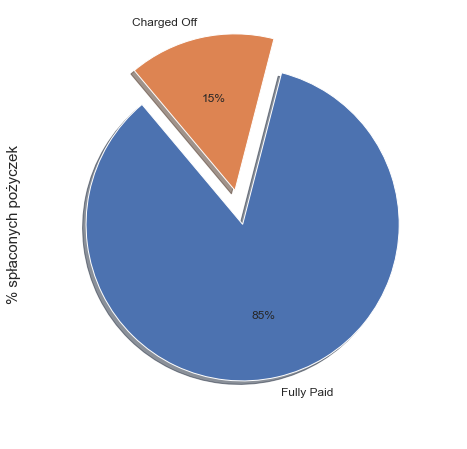

In [108]:
print(df["loan_status"].value_counts())

plt.figure(figsize=(16,8))
labels = "Fully Paid", "Charged Off"
df["loan_status"].value_counts().plot.pie(explode=[0,0.2], autopct='%.0f%%', radius=0.9,
                                       shadow=True, 
                                       fontsize=12, startangle=130)

plt.ylabel('% spłaconych pożyczek', fontsize=15)
plt.show()

Spłaconych pożyczek jest 85%, a niespłaconych 15%

Klasy są niezbalansowane.




-------------------------------------------------------------------------------------------------------------------

SPŁACALNOŚĆ A WSKAŹNIK FICO

Jest pięć grup skoringowych:
    
    Poor: < 580
    
    Fair: 580-669
    
    Good: 670-739
    
    Very Good: 740-799
    
    Exceptional: >=800


In [109]:
df.fico_avg.head()

0    737.0
1    742.0
2    737.0
3    692.0
4    697.0
Name: fico_avg, dtype: float64

In [110]:
print('Range of values frh: ', df['fico_avg'].max()-df['fico_avg'].min())

Range of values frh:  215.0


In [111]:
print('Minimum fico: ', df['fico_avg'].min())
print('Maximum fico: ', df['fico_avg'].max())
print('Mean value fico: ', df['fico_avg'].mean())
print('Mode value fico: ', df['fico_avg'].mode()[0])
print('Median value fico: ',df['fico_avg'].median())
print('Standard deviation fico: ', df['fico_avg'].std())

Minimum fico:  612.0
Maximum fico:  827.0
Mean value fico:  715.0525449629716
Mode value fico:  687.0
Median value fico:  712.0
Standard deviation fico:  36.188438536332605


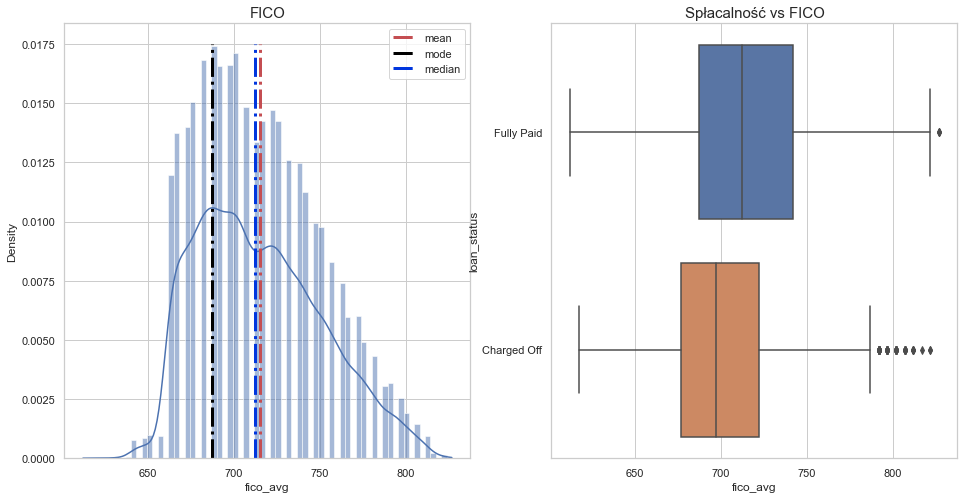

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

mean = df["fico_avg"].mean()
mode = df["fico_avg"].mode()
median = df["fico_avg"].median()

sns.histplot(df["fico_avg"], stat="density", kde=True, ax=axs[0])
axs[0].plot([mean, mean], [0, 0.0175], "r-.", label="mean", linewidth=3)
axs[0].plot([mode, mode], [0, 0.0175], "-.", color="#000000", label="mode", linewidth=3)
axs[0].plot([median, median], [0, 0.0175], "-.", color="#0036de", label="median", linewidth=3)
axs[0].set_title("FICO", fontsize=15)
axs[0].legend()

sns.boxplot(x = 'fico_avg', y='loan_status', data=df, ax=axs[1])
axs[1].set_title("Spłacalność vs FICO", fontsize=15)

plt.show()

Wartości wskaźnika FICO zaczynają się od 612 i kończą na 827

Najczęściej występującą wartością jest wartość 687 (rating 'Good')

Średnia i mediana mają wartośći bardzo zbliżone i jest to odpowiednio 715 i 712 (też rating 'Good')

Rozkład jest prawostronnie skośny

Wartości poniżej 660 jest bardzo mało, a powyżej ich ilość rośnie skokowo


Jeżeli chodzi o spłacalność pożyczek to jest ona związana z ratingiem FICO

Wraz ze wzrostem wskaźnika fico rośnie prawdopodobieństwo spłacenia pożyczki.

Im wyższy wskaźnik fico, tym prawdopodobieństwo spłacenia pożyczki też jest wyższe. 

Przy wskaźniku FICO powyżej ok.725 ryzyko, że pożyczka nie będzie spłacona jest niewielkie, 

natomiast przy wskaźniku poniżej ok. 680 prawdopodobieństwo niespłacenia pożyczki jest bardzo duże.


<AxesSubplot:>

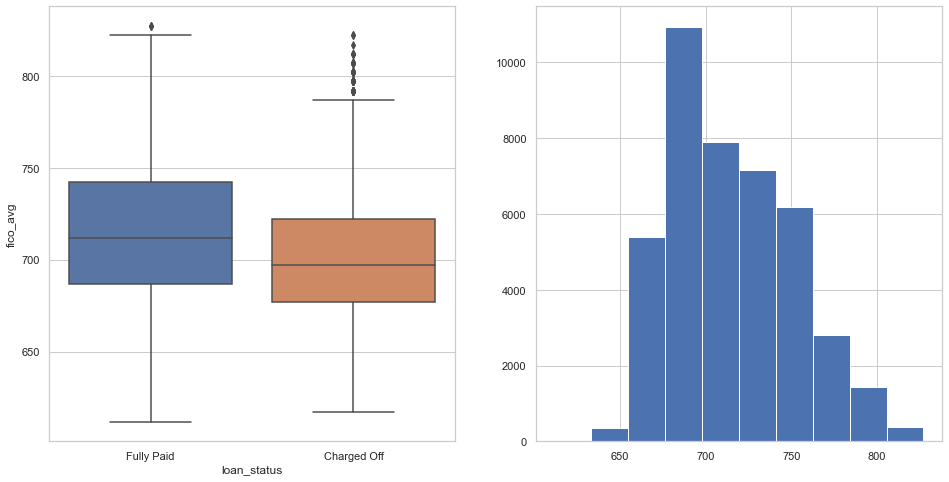

In [113]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.boxplot(data=df, x='loan_status', y='fico_avg')

plt.subplot(1,2,2)
df.fico_avg.hist()

-------------------------------------------------------------------------------------------------------------------

SPŁACALNOŚĆ A HISTORIA KREDYTOWA

Zmienna 'earliest_credit_line'

In [114]:
df['earliest_cr_line'] = pd.DatetimeIndex(df['earliest_cr_line']).year
df['earliest_cr_line']

0        1985
1        1999
2        2001
3        1996
4        1996
         ... 
42531    1999
42532    1999
42533    1999
42534    1999
42535    1999
Name: earliest_cr_line, Length: 42535, dtype: int64

In [115]:
print('Minimum earliest_cr_line: ', df['earliest_cr_line'].min())
print('Maximum earliest_cr_line: ', df['earliest_cr_line'].max())
print('Mean value earliest_cr_line: ', df['earliest_cr_line'].mean())
print('Mode value earliest_cr_line: ', df['earliest_cr_line'].mode()[0])
print('Median value earliest_cr_line: ',df['earliest_cr_line'].median())
print('Standard deviation earliest_cr_line: ', df['earliest_cr_line'].std())

Minimum earliest_cr_line:  1946
Maximum earliest_cr_line:  2008
Mean value earliest_cr_line:  1996.5843423063359
Mode value earliest_cr_line:  2000
Median value earliest_cr_line:  1998.0
Standard deviation earliest_cr_line:  6.838072239677751


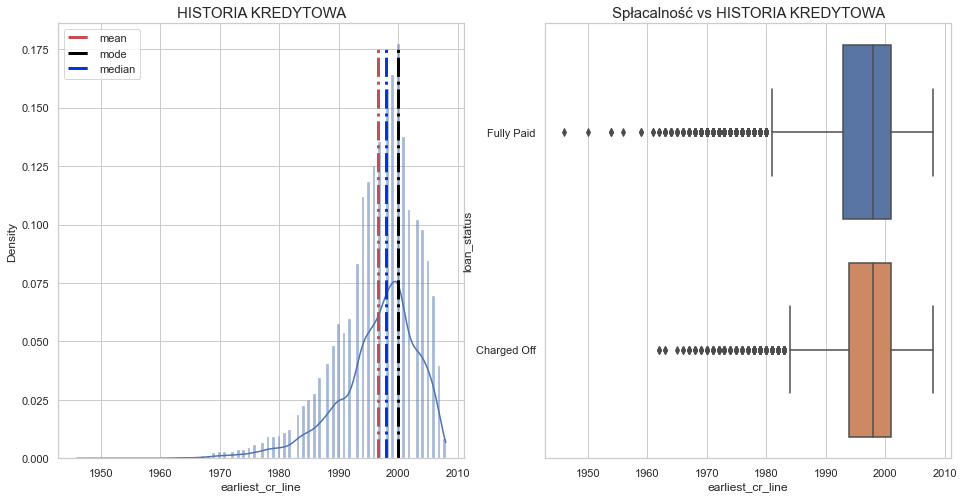

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

mean = df["earliest_cr_line"].mean()
mode = df["earliest_cr_line"].mode()
median = df["earliest_cr_line"].median()

sns.histplot(df["earliest_cr_line"], stat="density", kde=True, ax=axs[0])
axs[0].plot([mean, mean], [0, 0.175], "r-.", label="mean", linewidth=3)
axs[0].plot([mode, mode], [0, 0.175], "-.", color="#000000", label="mode", linewidth=3)
axs[0].plot([median, median], [0, 0.175], "-.", color="#0036de", label="median", linewidth=3)
axs[0].set_title("HISTORIA KREDYTOWA", fontsize=15)
axs[0].legend()

sns.boxplot(x = 'earliest_cr_line', y='loan_status', data=df, ax=axs[1])
axs[1].set_title("Spłacalność vs HISTORIA KREDYTOWA", fontsize=15)

plt.show()

Text(0, 0.5, 'Historia kredytowa')

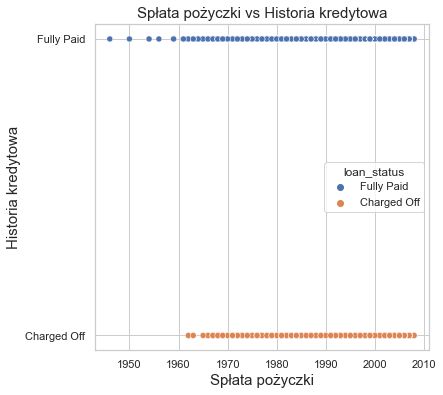

In [117]:
plt.figure(figsize=(6, 6))

sns.scatterplot(y="loan_status", x="earliest_cr_line", data=df, hue=df["loan_status"])
plt.title("Spłata pożyczki vs Historia kredytowa", fontsize=15)
plt.xlabel("Spłata pożyczki", fontsize=15)
plt.ylabel("Historia kredytowa", fontsize=15)

In [118]:
df[df.earliest_cr_line < 1960].count()

loan_amnt                 7
funded_amnt               7
funded_amnt_inv           7
term                      7
int_rate                  7
installment               7
grade                     7
sub_grade                 7
emp_length                7
home_ownership            7
annual_inc                7
verification_status       7
issue_d                   7
loan_status               7
purpose                   7
addr_state                7
dti                       7
delinq_2yrs               7
earliest_cr_line          7
inq_last_6mths            7
mths_since_last_delinq    7
open_acc                  7
pub_rec                   7
revol_bal                 7
revol_util                7
total_acc                 7
pub_rec_bankruptcies      7
fico_avg                  7
last_fico_avg             7
dtype: int64

Wiek kredytowy nie ma większego znaczenia na spłacalność pożyczki, aczkolwiek przy historii kredytowej poniżej 1960 

roku, nie ma praktycznie pożyczek niespłaconych, ale tych najstarszych klientów jest bardzo znikoma ilość, było ich 

zaledwie siedmiu

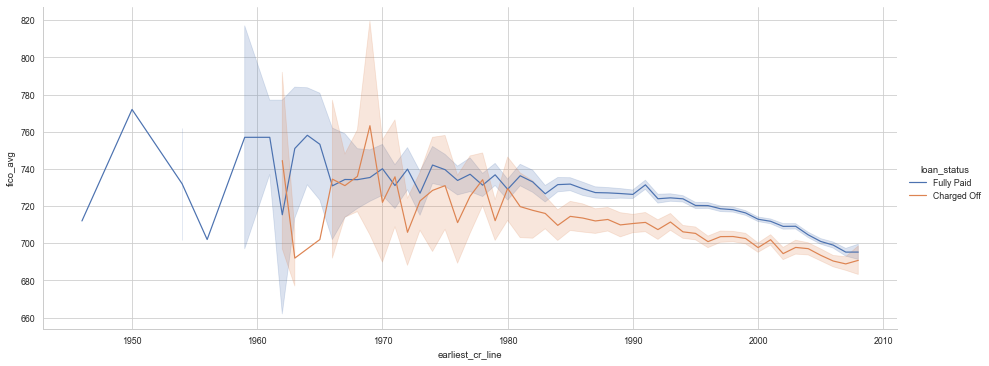

In [119]:
sns.set_context('paper')
sns.relplot(data=df,
            x="earliest_cr_line",
            y="fico_avg",
            aspect=2.5, 
            kind='line',
            hue='loan_status')
plt.show()

In [120]:
df.fico_avg.corr(df.earliest_cr_line)

-0.23499196957359278

Z powyższego wykresu wynika, że rating FICO jest związany z historią kredytową - im dłuższa, tym rating jest 

wyższy, ale nie jest to zależnośc bardzo mocna, o czym świadczy współczynnik korelacji na poziomie -0,235

-------------------------------------------------------------------------------------------------------------------

SPŁACALNOŚĆ A STATUS MIESZKANIOWY

Największą grupę stanowią klienci wynajmujący lokale, w których mieszkają i jest ich 47%

Klientów ze statusem mieszkaniowym "MORTAGE' - hipoteka jest nieiele mniej, bo 45%

Spłacalność wśród tej grupy klientów wynosi 84%

Tak więc nie można powiedzieć, by forma własności domu miała znaczący wpływ na spłacalność pożyczek. 

In [121]:
df.home_ownership.value_counts()

RENT        20181
MORTGAGE    18959
OWN          3251
OTHER         136
NONE            8
Name: home_ownership, dtype: int64

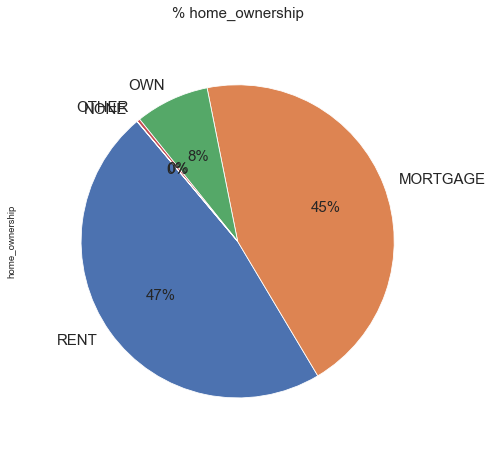

In [122]:
plt.figure(figsize=(16,8))

labels = "RENT", "MORTGAGE", "OWN"
df["home_ownership"].value_counts().plot.pie(autopct='%.0f%%', radius=0.9,
                                        fontsize=15, startangle=130)

plt.title('% home_ownership', fontsize=15)
plt.show()

In [123]:
df_cross = pd.crosstab(df['home_ownership'], df['loan_status'])
print(df_cross)

loan_status     Charged Off  Fully Paid
home_ownership                         
MORTGAGE               2699       16260
NONE                      1           7
OTHER                    29         107
OWN                     495        2756
RENT                   3207       16974


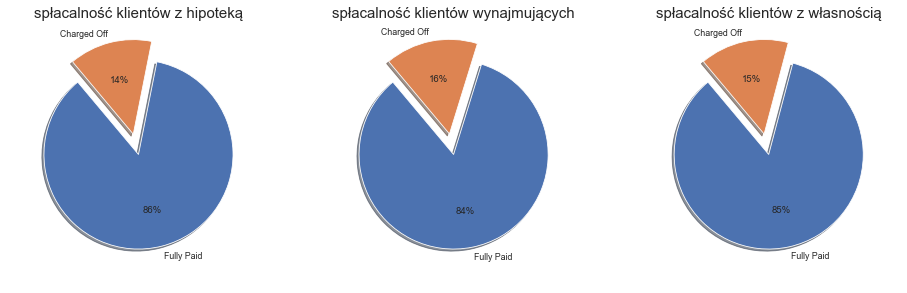

In [124]:
plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
y = np.array([16260, 2699])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z hipoteką', fontsize=15)

plt.subplot(1,3,2)
y = np.array([16974, 3207])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów wynajmujących', fontsize=15)

plt.subplot(1,3,3)
y = np.array([2756, 495])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z własnością', fontsize=15)
plt.show()

Z powyższych wykresów również wynika, że w każdej grupie pożyczkobiorców, wyniki rozkładają się podobnie.

Aby się upewnić, sprawdzę zależność między zmiennymi za pomocą Chi-Square test:
    
    H0 - nie ma zależności między spłacalnością a statusem mieszkaniowym
    
    H1 - są relacje między zmiennymi

In [125]:
stat, p_value, dof, expected = chi2_contingency(df_cross)
alpha = 0.05
print(p_value)

4.922904146937375e-05


In [126]:
if p_value <= alpha:
    print('ODZRZUCAMY HO - są zależności między zmiennymi')
else:
    print('AKCEPTUJEMY H0 - nie ma zależności między zmiennymi')

ODZRZUCAMY HO - są zależności między zmiennymi


-------------------------------------------------------------------------------------------------------------------

SPŁACALNOŚĆ A DOCHÓD

zmienna annual_income

In [127]:
df['annual_inc'].describe()

count    4.253500e+04
mean     6.913570e+04
std      6.409340e+04
min      1.896000e+03
25%      4.000000e+04
50%      5.900000e+04
75%      8.250000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [128]:
print('Minimalny dochód roczny: ', df['annual_inc'].min())
print('Maksymalny dochód roczny: ', df['annual_inc'].max())
print('Średni dochód roczny: ', df['annual_inc'].mean())
print('Najczęściej występujący dochód roczny: ', df['annual_inc'].mode()[0])
print('Mediana dochodu rocznego: ',df['annual_inc'].median())
print('Odchylenie standardowe dochodu rocznego: ', df['annual_inc'].std())

Minimalny dochód roczny:  1896.0
Maksymalny dochód roczny:  6000000.0
Średni dochód roczny:  69135.69721664517
Najczęściej występujący dochód roczny:  60000.0
Mediana dochodu rocznego:  59000.0
Odchylenie standardowe dochodu rocznego:  64093.39699604612


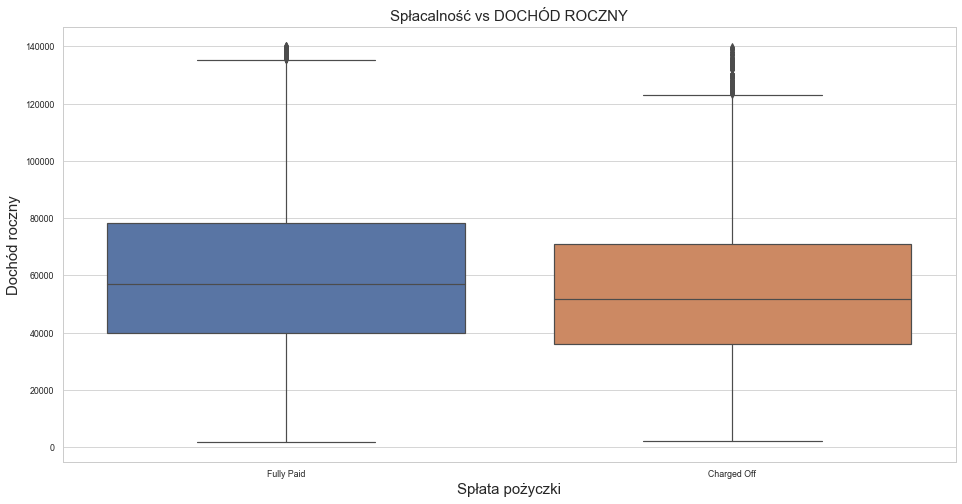

In [129]:
plt.figure(figsize=(16,8))

sns.boxplot(y = 'annual_inc', x='loan_status', data=df[df['annual_inc'] < 140000])
plt.ylabel('Dochód roczny', fontsize=15)
plt.xlabel('Spłata pożyczki',fontsize=15)
plt.title("Spłacalność vs DOCHÓD ROCZNY", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Rozkład dochodu rocznego')

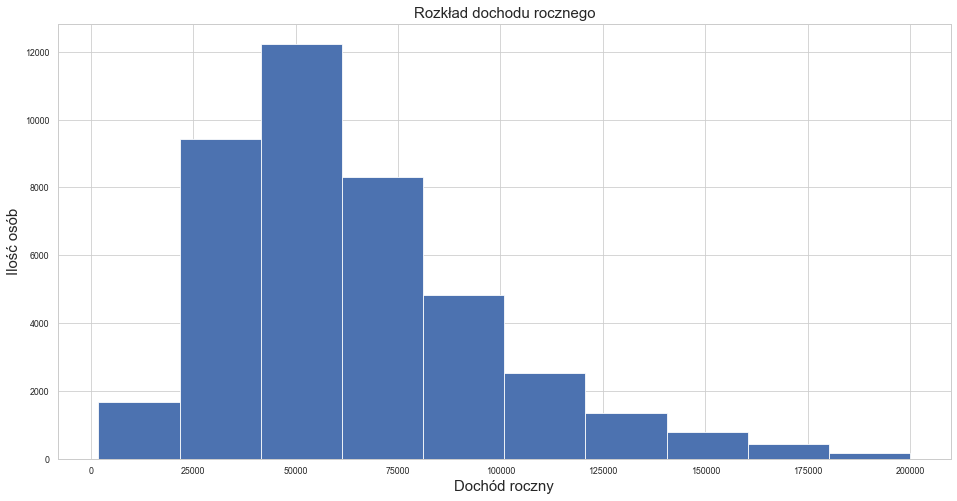

In [130]:
plt.figure(figsize=(16, 8))

df1=df[df['annual_inc'] < 200000]
df1.annual_inc.hist()
plt.xlabel('Dochód roczny', fontsize=15)
plt.ylabel('Ilość osób',fontsize=15)
plt.title('Rozkład dochodu rocznego', fontsize=15)

Średnia wysokość dochodu rocznego jest wyższa u klientów spłacających swoje pożyczki.

Natomiast najwięcej pożyczkobiorców zarabia między 40 a 65 tys dolarów rocznie.

-------------------------------------------------------------------------------------------------------------------

SPŁACALNOŚĆ A DŁUGOŚĆ ZATRUDNIENIA

zmienna emp_length

In [131]:
df['emp_length'].describe()

count    42535.000000
mean         5.055813
std          3.613600
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64

Text(0.5, 0, 'Długość zatrudnienia')

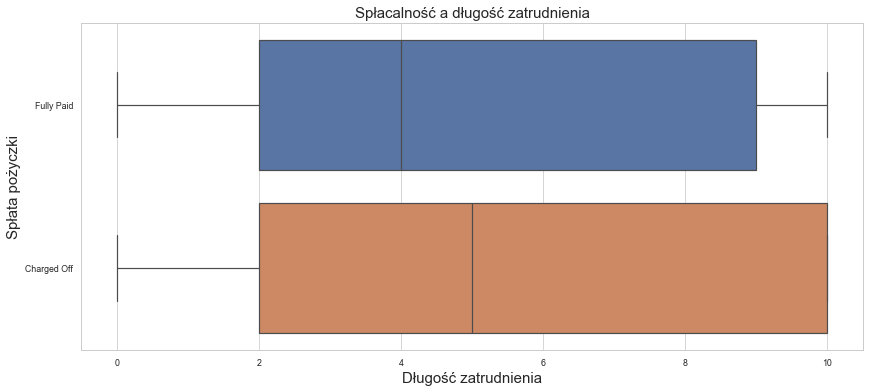

In [132]:
plt.figure(figsize=(14,6))

sns.boxplot(x="emp_length", y="loan_status", data=df)
plt.title("Spłacalność a długość zatrudnienia", fontsize=15)
plt.ylabel("Spłata pożyczki", fontsize=15)
plt.xlabel("Długość zatrudnienia", fontsize=15)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


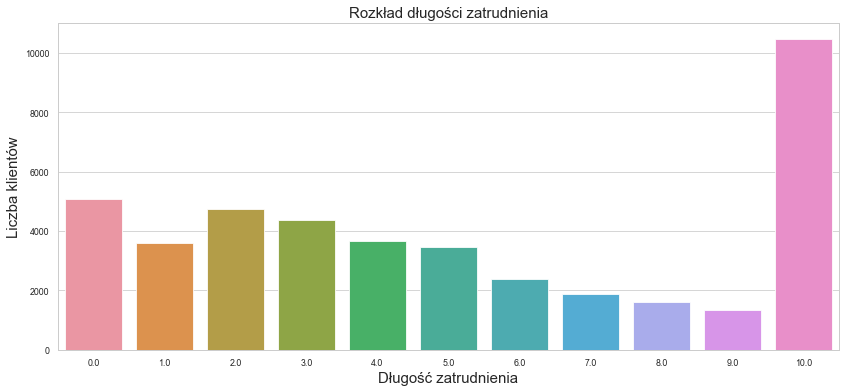

In [133]:
plt.figure(figsize=(14,6))

sns.countplot(df["emp_length"])
plt.title("Rozkład długości zatrudnienia", fontsize=15)
plt.ylabel("Liczba klientów", fontsize=15)
plt.xlabel("Długość zatrudnienia", fontsize=15)
plt.show()

Pożyczkobiorcy zatrudnieni 10 lat i więcej stanowią najliczniejszą grupę.

In [134]:
df_cross = pd.crosstab(df['emp_length'], df['loan_status'])
print(df_cross)

loan_status  Charged Off  Fully Paid
emp_length                          
0.0                  751        4311
1.0                  551        3044
2.0                  654        4089
3.0                  630        3734
4.0                  522        3127
5.0                  509        2949
6.0                  352        2023
7.0                  295        1580
8.0                  238        1354
9.0                  180        1161
10.0                1749        8732


Text(0.5, 1.0, 'spłacalność pracujących 10 lat i więcej')

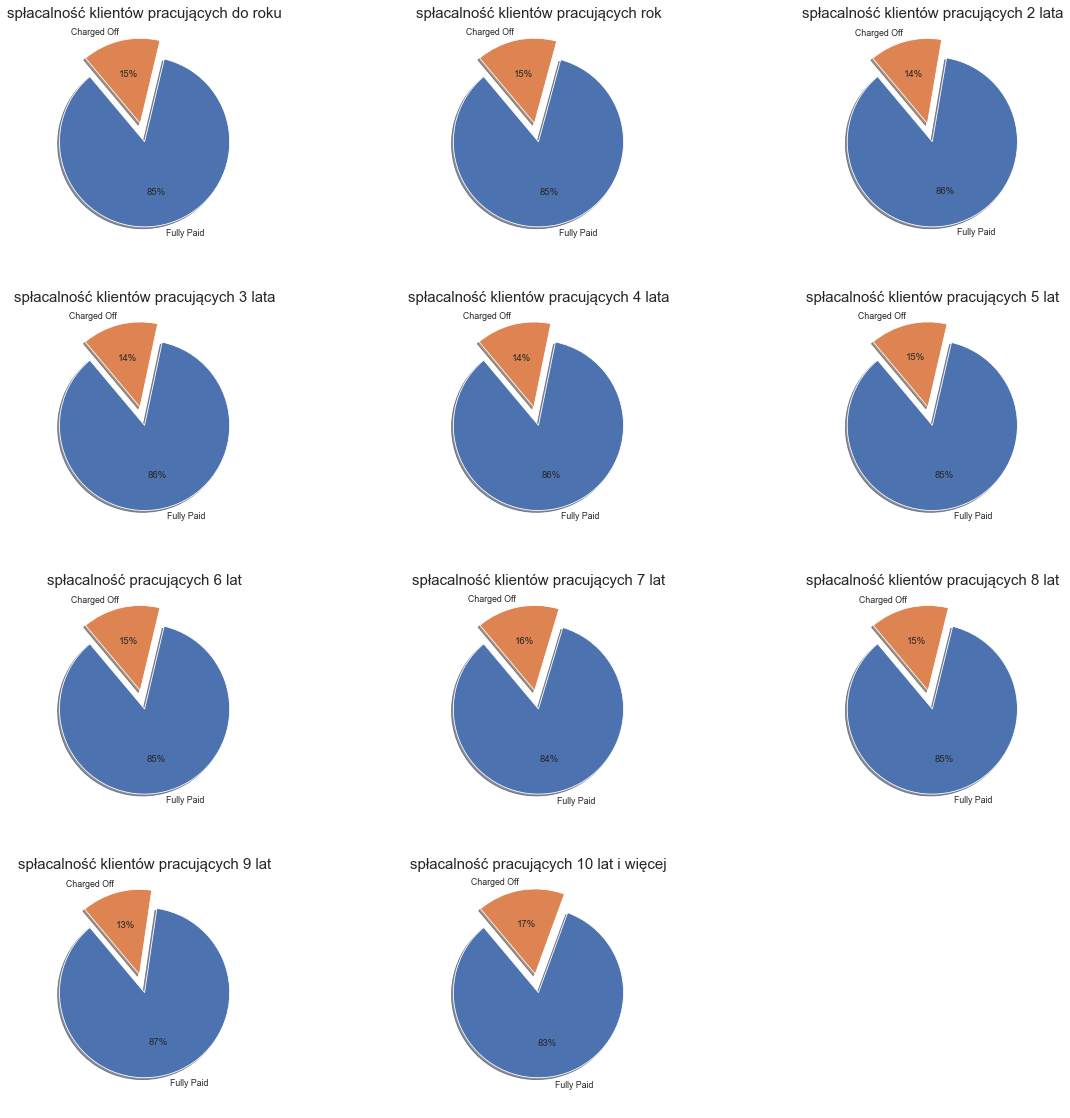

In [135]:
plt.figure(figsize=(20,20))

plt.subplot(4,3,1)
y = np.array([4311, 751])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących do roku', fontsize=15)

plt.subplot(4,3,2)
y = np.array([3044, 551])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących rok', fontsize=15)

plt.subplot(4,3,3)
y = np.array([4089, 654])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących 2 lata', fontsize=15)

plt.subplot(4,3,4)
y = np.array([3734, 630])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących 3 lata', fontsize=15)

plt.subplot(4,3,5)
y = np.array([3127, 522])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących 4 lata', fontsize=15)

plt.subplot(4,3,6)
y = np.array([2949, 509 ])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących 5 lat', fontsize=15)

plt.subplot(4,3,7)
y = np.array([2023, 352])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność pracujących 6 lat', fontsize=15)

plt.subplot(4,3,8)
y = np.array([1580, 295])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących 7 lat', fontsize=15)

plt.subplot(4,3,9)
y = np.array([1354, 238])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących 8 lat', fontsize=15)

plt.subplot(4,3,10)
y = np.array([1161, 180])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów pracujących 9 lat', fontsize=15)

plt.subplot(4,3,11)
y = np.array([8732, 1749])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność pracujących 10 lat i więcej', fontsize=15)

W każdej grupie pożyczkobiorców wyniki rozkładają się podobnie.

Jak widać spłacanie pożyczki nie jest związana z długością zatrudnienia

-------------------------------------------------------------------------------------------------------------------

WYSOKOŚĆ POŻYCZKI

zmienna loan_amnt

In [136]:
df['loan_amnt'].describe()

count    42535.000000
mean     11089.722581
std       7410.938391
min        500.000000
25%       5200.000000
50%       9700.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

Text(0, 0.5, 'Wysokość pożyczki')

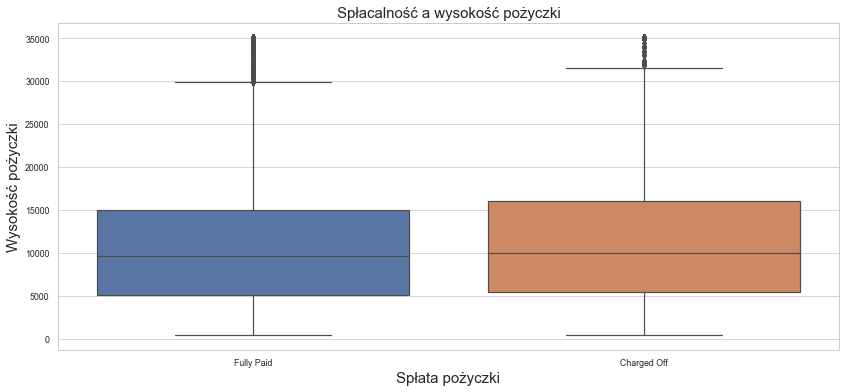

In [137]:
plt.figure(figsize=(14,6))

sns.boxplot(y="loan_amnt", x="loan_status", data=df)
plt.title("Spłacalność a wysokość pożyczki", fontsize=15)
plt.xlabel("Spłata pożyczki", fontsize=15)
plt.ylabel("Wysokość pożyczki", fontsize=15)

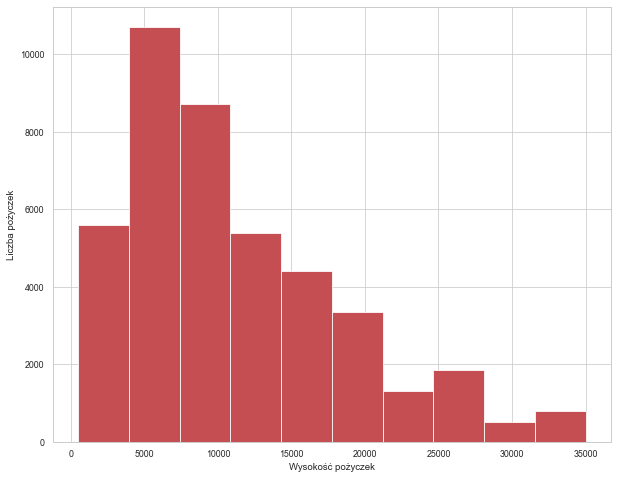

In [138]:
df.loan_amnt.hist(figsize=(10,8), color='r')
plt.ylabel('Liczba pożyczek')
plt.xlabel('Wysokość pożyczek')
plt.show()

Najwięcej pożyczek jest udzielanych w wysokości między 5 a 10 tysięcy.

Pożyczki powyżej 15tys są obarczone większym ryzykiem niespłacenia.

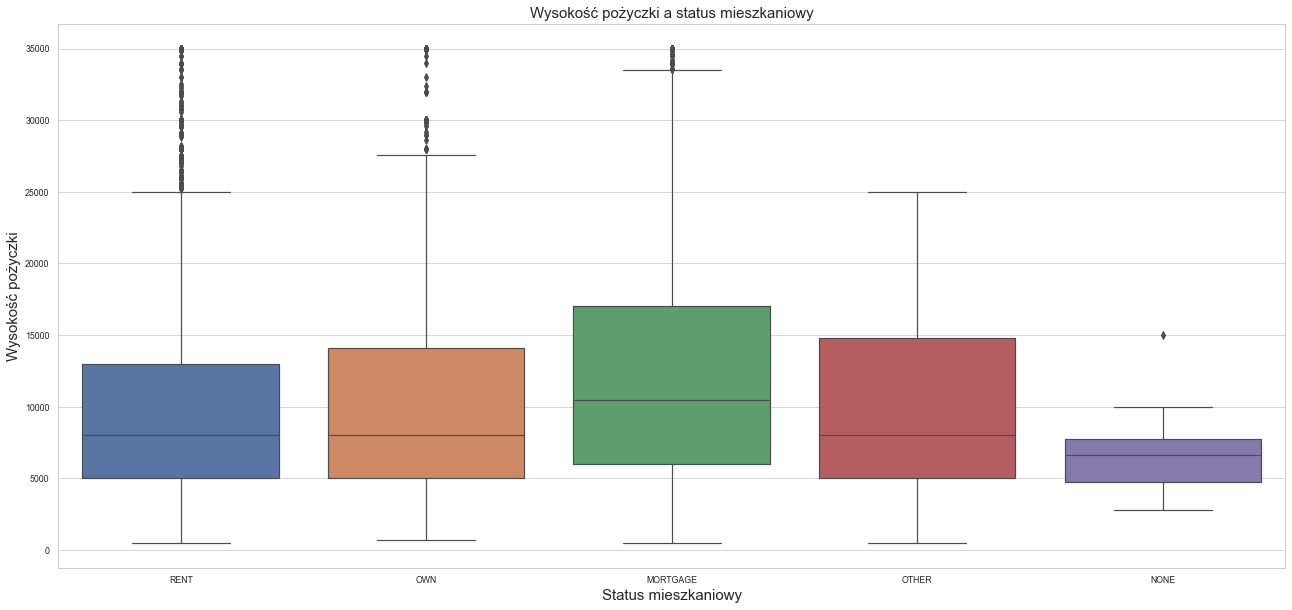

In [139]:
plt.figure(figsize=(22,10))
sns.boxplot(x="home_ownership", y="loan_amnt", data=df)
plt.title('Wysokość pożyczki a status mieszkaniowy', fontsize=15)
plt.xlabel('Status mieszkaniowy', fontsize=15)
plt.ylabel("Wysokość pożyczki", fontsize=15)
plt.show()

Najwyższe pożyczki otrzymują właściciele hipotek. Pożyczka powyżej 15tys nie jest możliwa, gdy nie masz hipteki.

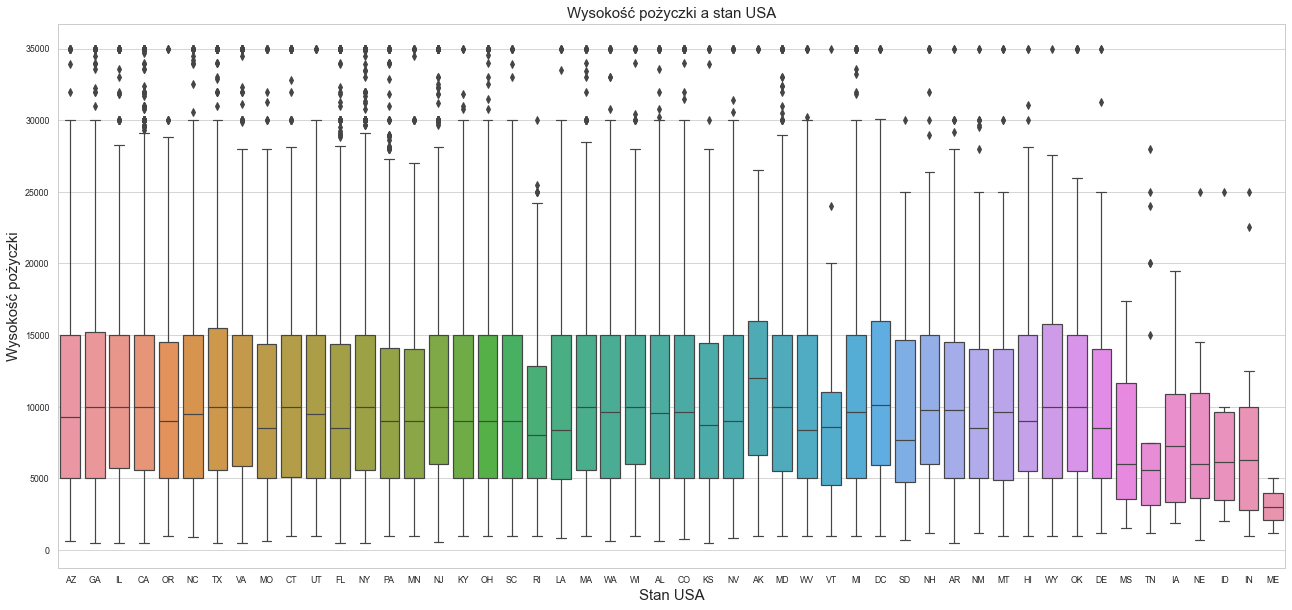

In [140]:
plt.figure(figsize=(22,10))
sns.boxplot(x="addr_state", y="loan_amnt", data=df)
plt.title('Wysokość pożyczki a stan USA', fontsize=15)
plt.xlabel('Stan USA', fontsize=15)
plt.ylabel("Wysokość pożyczki", fontsize=15)
plt.show()

Średnia wysokość pożyczki jest najniższa w stanie Maine, niższa niż minimalna wysokość pożyczki w większości stanów 

USA. Natomiast najwyższa średnia pożyczek jest w stanie Alaska.

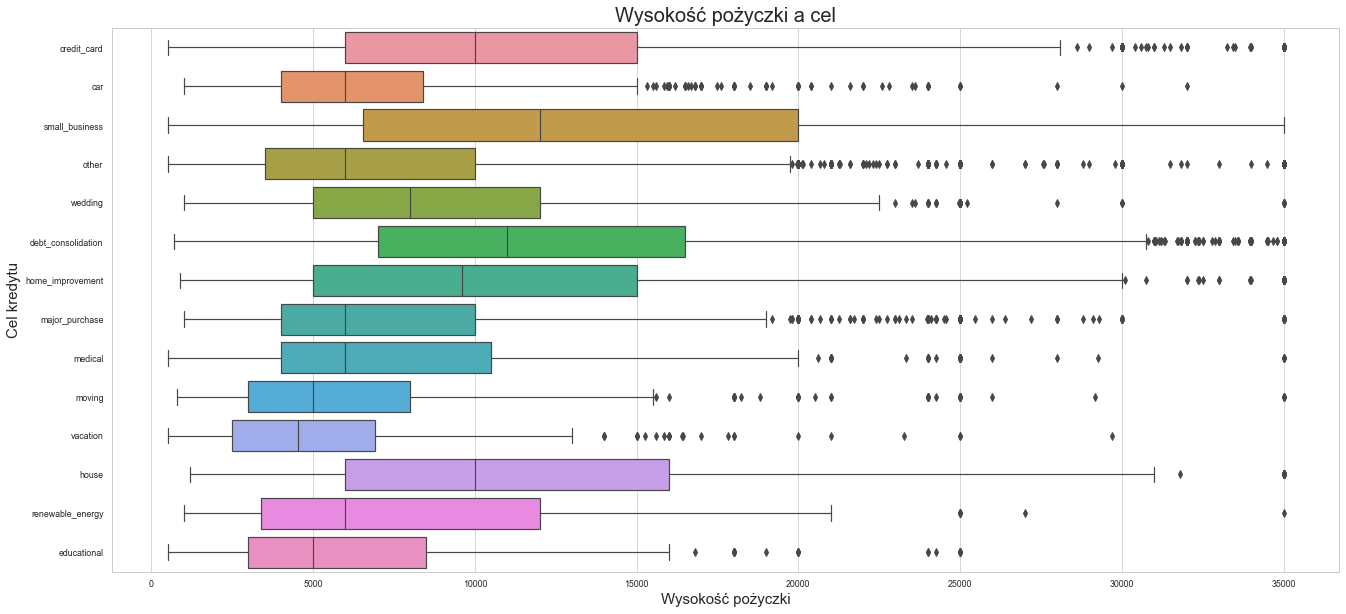

In [141]:
plt.figure(figsize=(22,10))
sns.boxplot(y="purpose", x="loan_amnt", data=df)
plt.title('Wysokość pożyczki a cel', fontsize=20)
plt.ylabel('Cel kredytu', fontsize=15)
plt.xlabel("Wysokość pożyczki", fontsize=15)
plt.show()

Większość niskich kredytów jest brana na zakup samochodu, wakacje i edukacje.

Największą wartość mają kredyty na rozwój małych firm, również ich średnia wartość jest najwyższa.

-------------------------------------------------------------------------------------------------------------------

STATUS WERYFIKACJI

zmienna verification_status

In [142]:
df.verification_status.value_counts()

Not Verified       18758
Verified           13471
Source Verified    10306
Name: verification_status, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


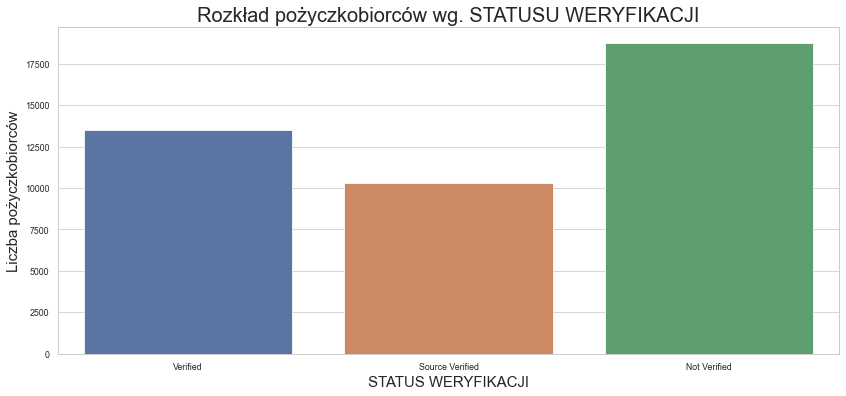

In [143]:
plt.figure(figsize=(14,6))
sns.countplot(df['verification_status'])
plt.title('Rozkład pożyczkobiorców wg. STATUSU WERYFIKACJI', fontsize=20)
plt.xlabel('STATUS WERYFIKACJI', fontsize=15)
plt.ylabel("Liczba pożyczkobiorców", fontsize=15)
plt.show()

Najwięcej jest pożyczek o statusie Not Verified.

Swoją drogą ciekawe jaka jest różnica między Verified a Source Verified

In [144]:
df_cross = pd.crosstab(df['verification_status'], df['loan_status'])
print(df_cross)

loan_status          Charged Off  Fully Paid
verification_status                         
Not Verified                2655       16103
Source Verified             1534        8772
Verified                    2242       11229


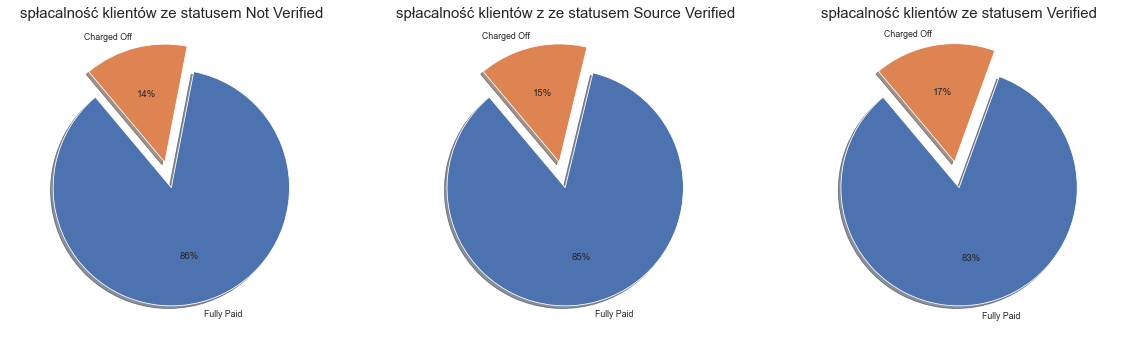

In [145]:
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
y = np.array([16103, 2655])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów ze statusem Not Verified', fontsize=15)

plt.subplot(1,3,2)
y = np.array([8772, 1534])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z ze statusem Source Verified', fontsize=15)

plt.subplot(1,3,3)
y = np.array([11229, 2242])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów ze statusem Verified', fontsize=15)
plt.show()

Status weryfikacji nie ma zbyt dużego wpływu na spłacalność pożyczki.

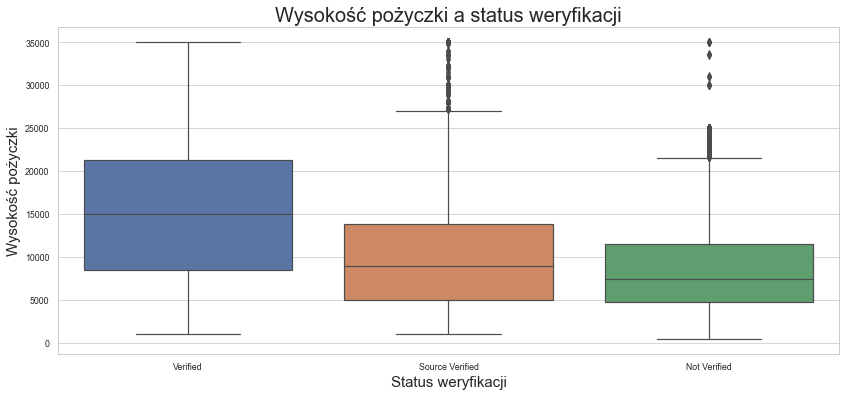

In [146]:
plt.figure(figsize=(14,6))
sns.boxplot(x="verification_status", y="loan_amnt", data=df)
plt.title('Wysokość pożyczki a status weryfikacji', fontsize=20)
plt.xlabel('Status weryfikacji', fontsize=15)
plt.ylabel("Wysokość pożyczki", fontsize=15)
plt.show()

Pożyczki o statusie zweryfikowane mają najwyższą średnią wartość - około 15tys.

Średnia wartość pożyczki niezweryfikowanej to 7tys

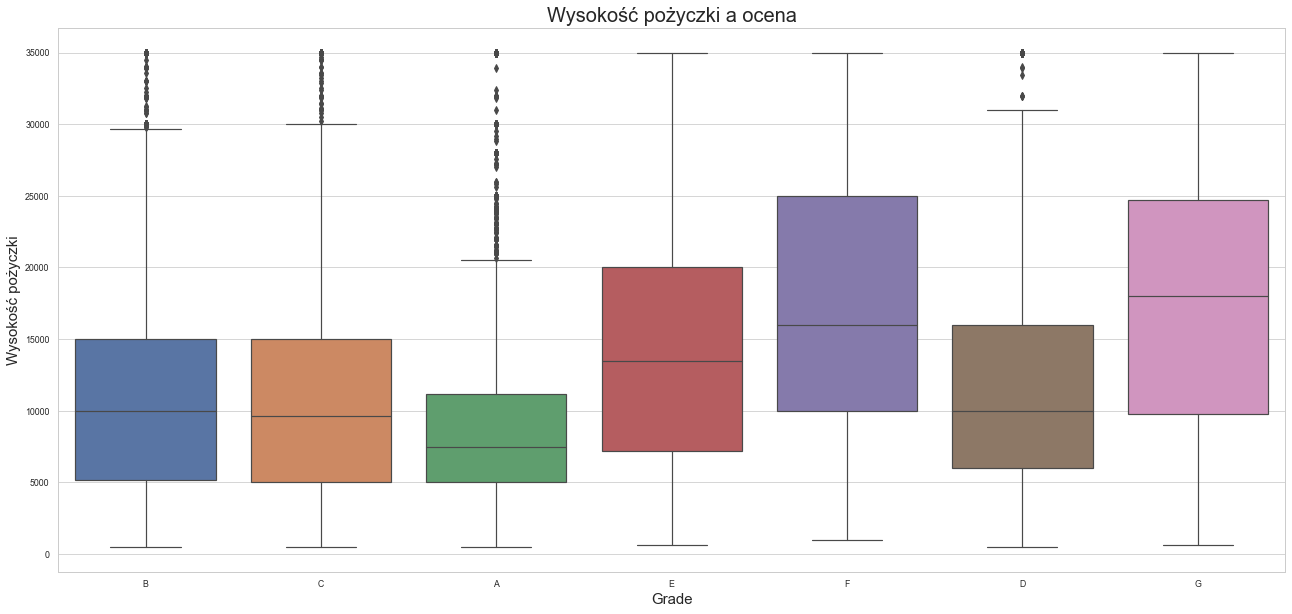

In [147]:
plt.figure(figsize=(22,10))
sns.boxplot(x="grade", y="loan_amnt", data=df)
plt.title('Wysokość pożyczki a ocena', fontsize=20)
plt.xlabel('Grade', fontsize=15)
plt.ylabel("Wysokość pożyczki", fontsize=15)
plt.show()

Najwięcej pożyczek jest udzielanych klientom z oceną F i G. 

Najwyższa średnia wartość pożyczki jest wśród klientów z najwyższą oceną.

Najniższa średnia wartość pożyczki jest wśród klientów z oceną A i jest ich też najmniej.

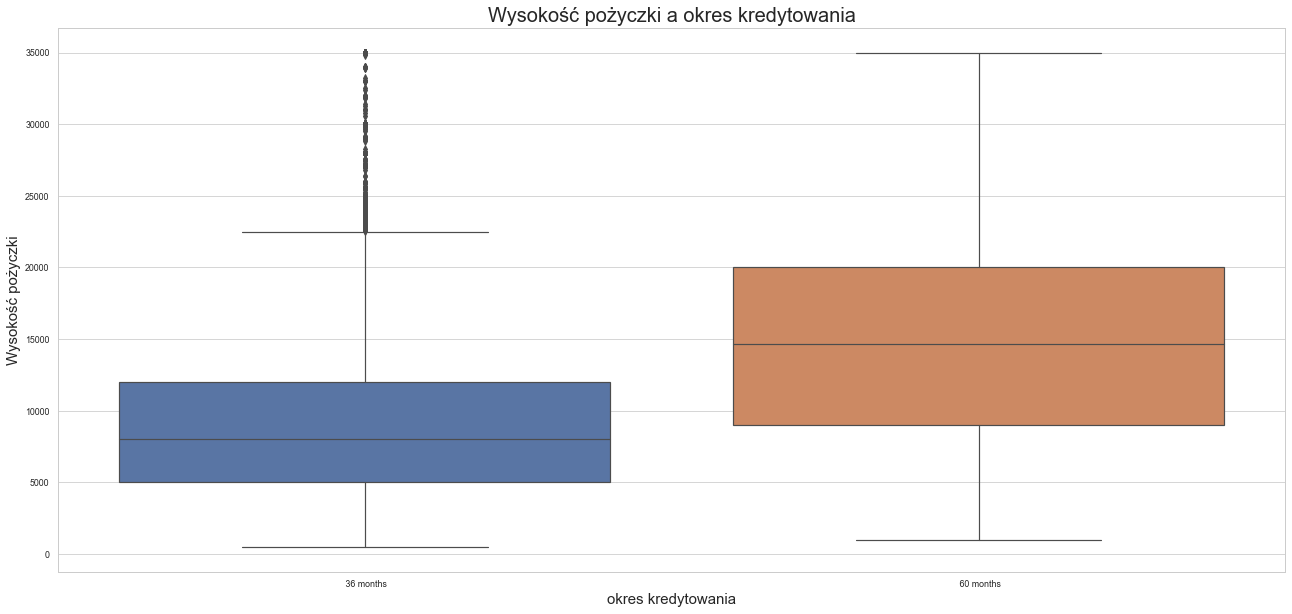

In [148]:
plt.figure(figsize=(22,10))
sns.boxplot(x="term", y="loan_amnt", data=df)
plt.title('Wysokość pożyczki a okres kredytowania', fontsize=20)
plt.xlabel('okres kredytowania', fontsize=15)
plt.ylabel("Wysokość pożyczki", fontsize=15)
plt.show()

Jak widać powyżej średnia wysokość pożyczki udzielonej na 60 miesięcy wynosi około 15tys dolarów i jest wyższa od 

średniej wysokości pożyczki udzielonej na 36 miesięcy o około 7.5tys dolarów.

-------------------------------------------------------------------------------------------------------------------

OCENA

zmienna grade

In [149]:
df.grade.value_counts()

B    12389
A    10183
C     8740
D     6016
E     3394
F     1301
G      512
Name: grade, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


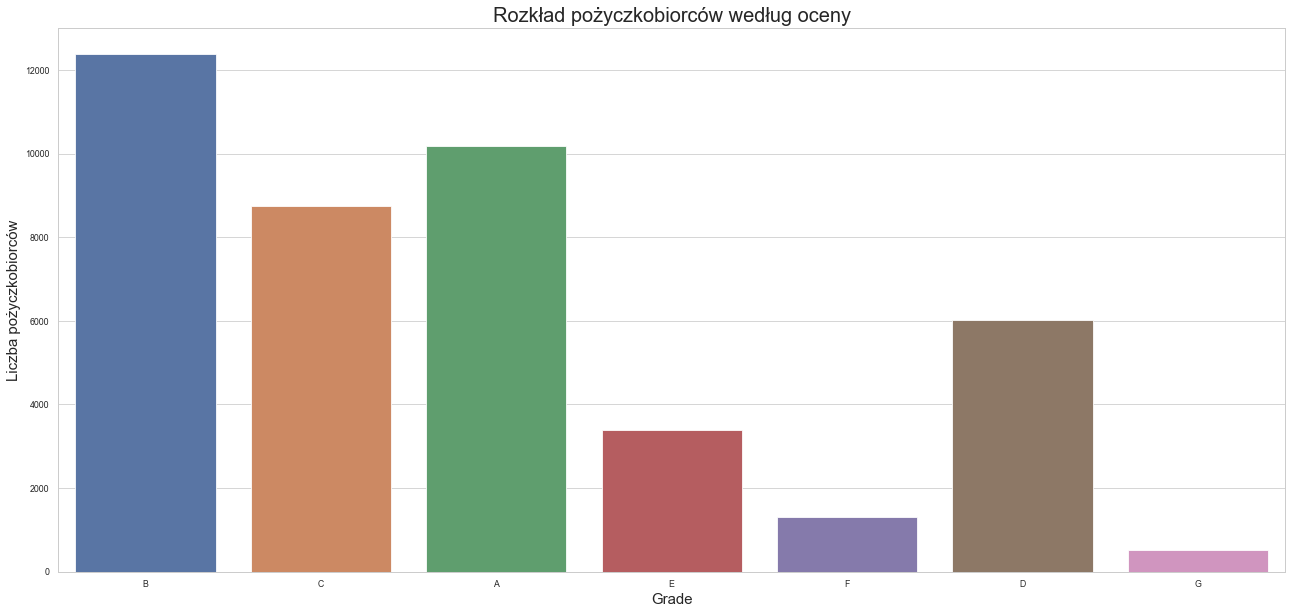

In [150]:
plt.figure(figsize=(22,10))
sns.countplot(df['grade'])
plt.title('Rozkład pożyczkobiorców według oceny', fontsize=20)
plt.xlabel('Grade', fontsize=15)
plt.ylabel("Liczba pożyczkobiorców", fontsize=15)
plt.show()

Najmniej pożyczkobiorców jest z oceną G.
Najwięcej pożyczkobiorców jest z ocenami B i A.

In [151]:
df_cross = pd.crosstab(df['grade'], df['loan_status'])
print(df_cross)

loan_status  Charged Off  Fully Paid
grade                               
A                    610        9573
B                   1518       10871
C                   1504        7236
D                   1327        4689
E                    883        2511
F                    416         885
G                    173         339


Text(0.5, 1.0, 'spłacalność klientów z oceną G')

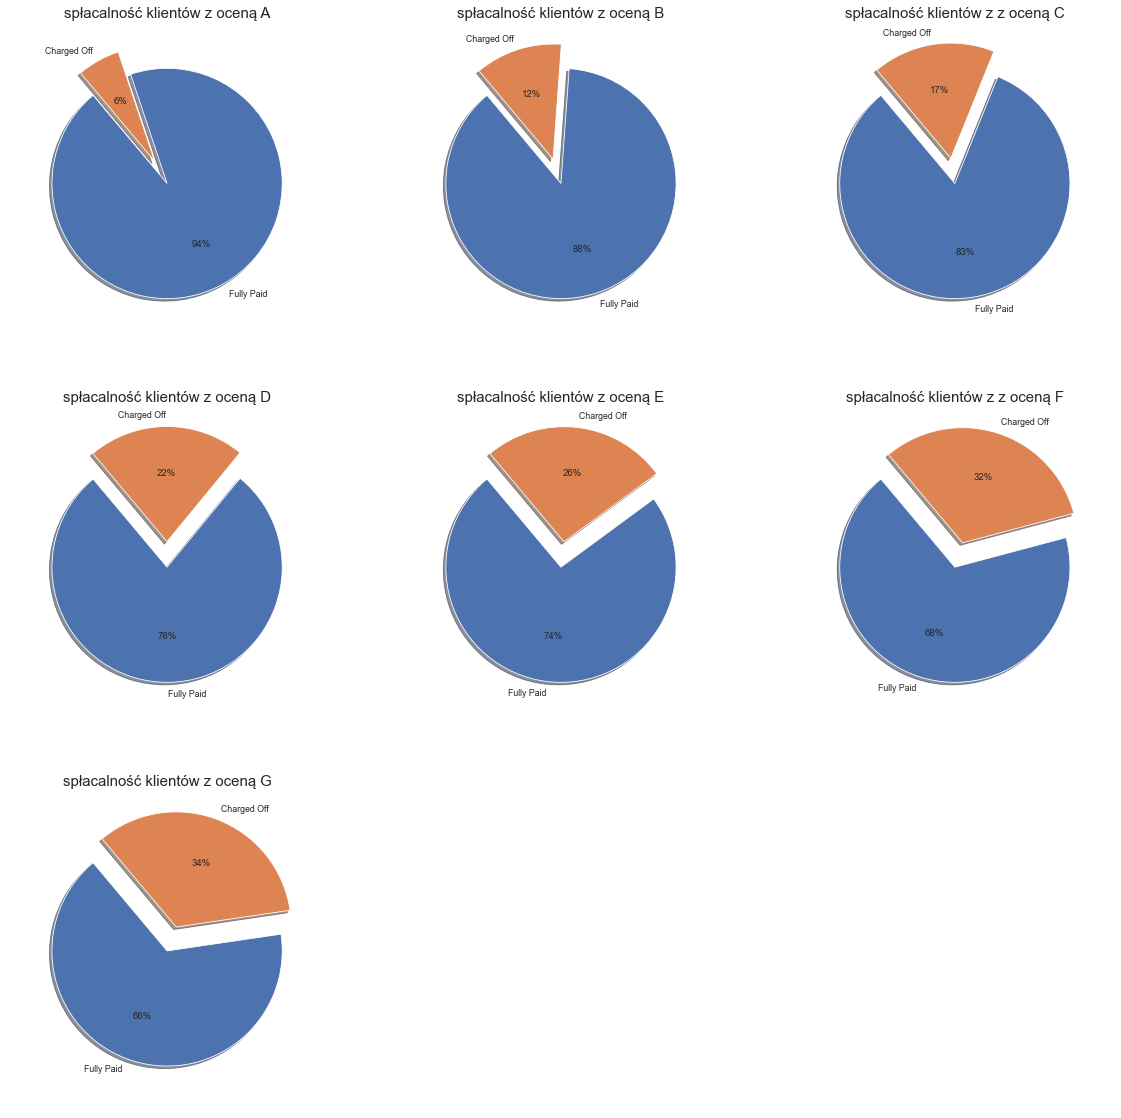

In [152]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
y = np.array([9573, 610])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z oceną A', fontsize=15)

plt.subplot(3,3,2)
y = np.array([10871, 1518])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z oceną B', fontsize=15)

plt.subplot(3,3,3)
y = np.array([7236, 1504])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z z oceną C', fontsize=15)

plt.subplot(3,3,4)
y = np.array([4689, 1327])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z oceną D', fontsize=15)

plt.subplot(3,3,5)
y = np.array([2511, 883])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z oceną E', fontsize=15)

plt.subplot(3,3,6)
y = np.array([885, 416])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z z oceną F', fontsize=15)

plt.subplot(3,3,7)
y = np.array([339, 173])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność klientów z oceną G', fontsize=15)

Najlepiej spłacają pożyczki klienci z oceną A - tylko 8% pożyczek niespłaconych.

Wsród klientów z oceną G niespłaconych jest aż 34% pożyczek.

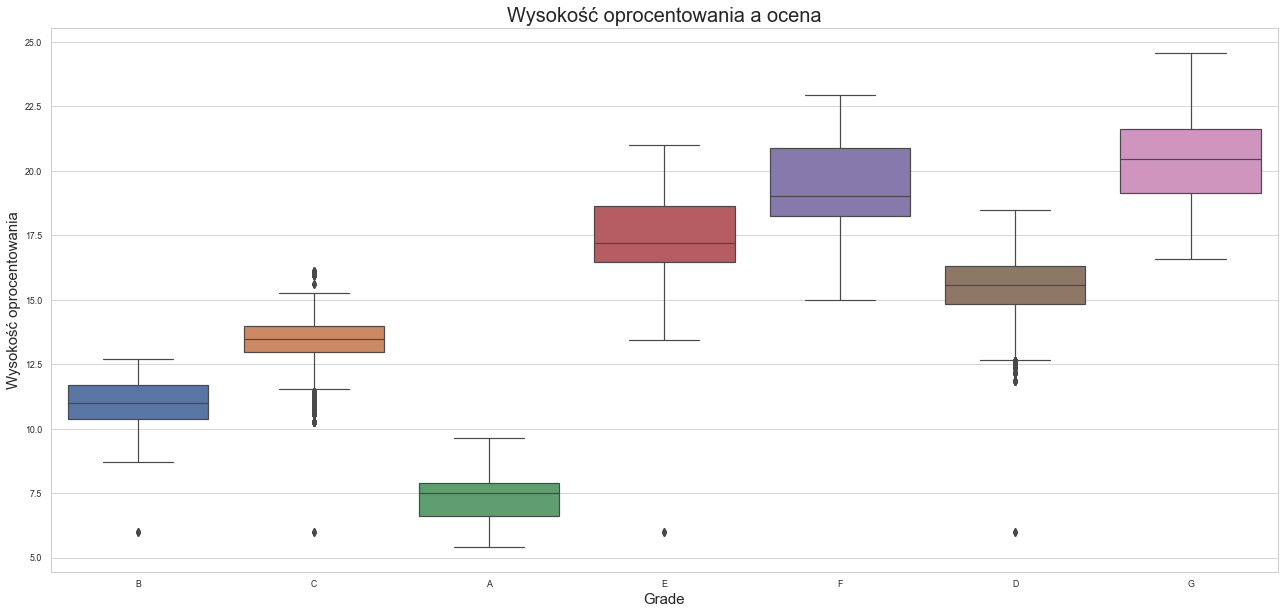

In [153]:
plt.figure(figsize=(22,10))
sns.boxplot(data=df, y='int_rate', x='grade')
plt.title('Wysokość oprocentowania a ocena', fontsize=20)
plt.xlabel('Grade', fontsize=15)
plt.ylabel("Wysokość oprocentowania", fontsize=15)
plt.show()

Pożyczkobiorcy z najwyższą oceną - A otrzymują najniższe oprocentowanie - średnio 7.5%. 

Z kolei klienci z najniższą oceną, muszą zapłacić najwyższe oprocentowanie - aż 21%

-------------------------------------------------------------------------------------------------------------------

OPROCENTOWANIE

zmienna int_rate

In [154]:
df.int_rate.describe()

count    42535.000000
mean        12.165016
std          3.707936
min          5.420000
25%          9.630000
50%         11.990000
75%         14.720000
max         24.590000
Name: int_rate, dtype: float64

Text(0, 0.5, 'Oprocentowanie')

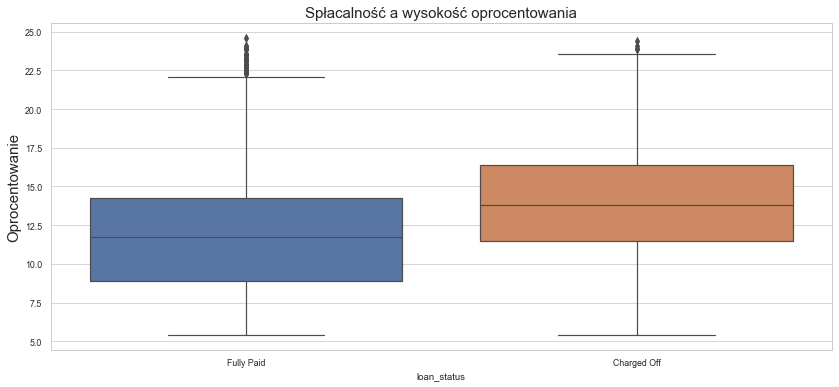

In [155]:
plt.figure(figsize=(14,6))

sns.boxplot(y="int_rate", x="loan_status", data=df)
plt.title("Spłacalność a wysokość oprocentowania", fontsize=15)
plt.ylabel("Oprocentowanie", fontsize=15)

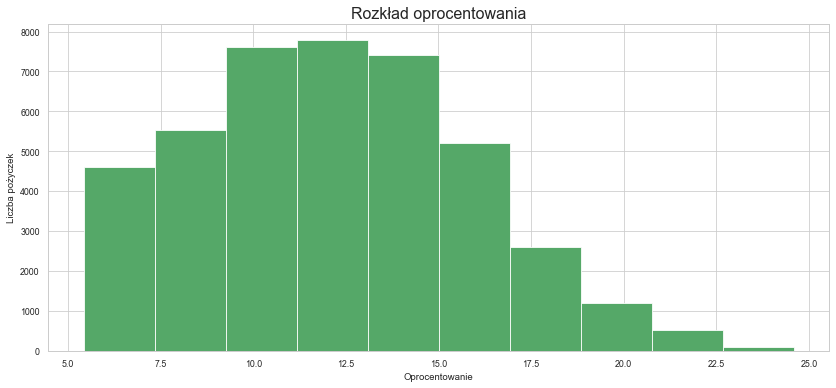

In [156]:
df.int_rate.hist(figsize=(14,6), color='g')
plt.ylabel('Liczba pożyczek')
plt.xlabel('Oprocentowanie')
plt.title("Rozkład oprocentowania", fontsize=16)
plt.show()

Najwięcej pożyczek udzielanych jest na 9 do 15%

Średnie oprocentowanie wsród spłacających wynosi 13%, a wsród tych którzy nie spłacili jest o 1% wyższe

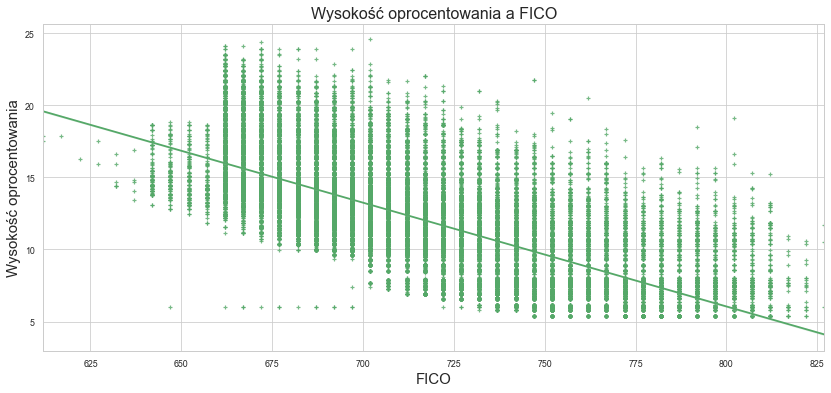

In [157]:
plt.figure(figsize=(14,6))
sns.regplot(y="int_rate", x="fico_avg", marker="+", data=df, color='g')
            
plt.xlabel("FICO",fontsize=15)
plt.ylabel("Wysokość oprocentowania",fontsize=15) 
plt.title("Wysokość oprocentowania a FICO", fontsize=16) 
plt.show()

Podobnie jak w przypadku zmiennej grade, im wyższe FICO tym niższe oprocentowanie.

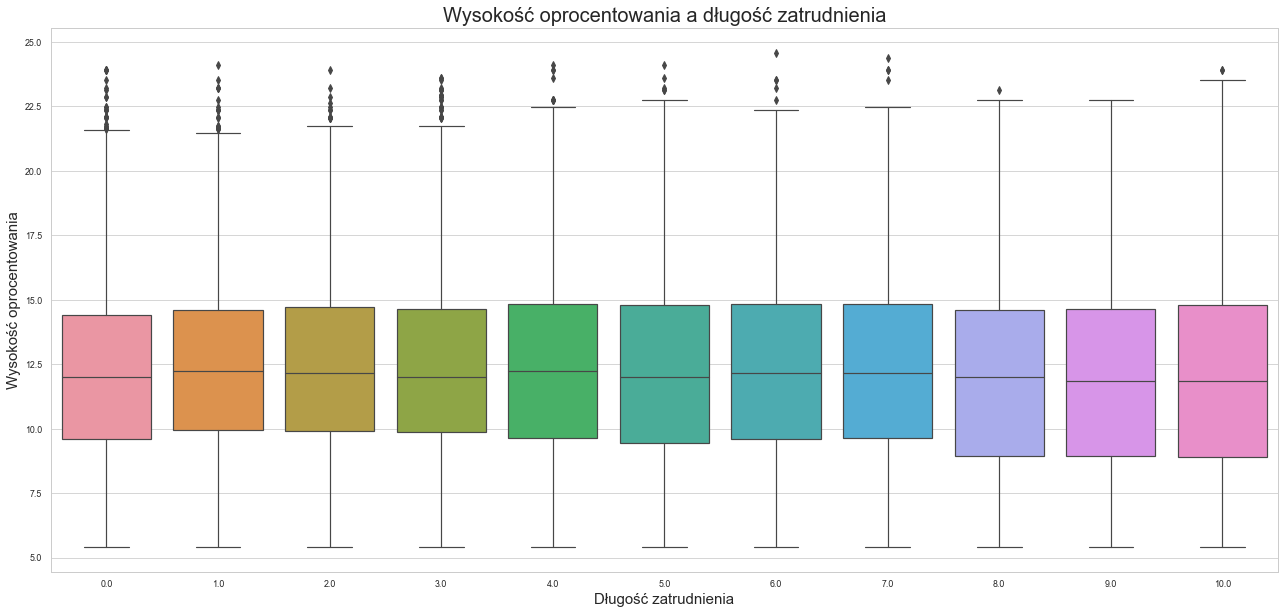

In [158]:
plt.figure(figsize=(22,10))
sns.boxplot(x="emp_length", y="int_rate", data=df)
plt.title('Wysokość oprocentowania a długość zatrudnienia', fontsize=20)
plt.xlabel('Długość zatrudnienia', fontsize=15)
plt.ylabel("Wysokość oprocentowania", fontsize=15)
plt.show()

Jak widać wysokość oprocentowania nie jest związana z długością zatrudnienia.

-------------------------------------------------------------------------------------------------------------------

WYSOKOŚĆ RATY

zmienna installment

In [159]:
df.installment.describe()

count    42535.000000
mean       322.623063
std        208.927216
min         15.670000
25%        165.520000
50%        277.690000
75%        428.180000
max       1305.190000
Name: installment, dtype: float64

Text(0, 0.5, 'Wysokość raty')

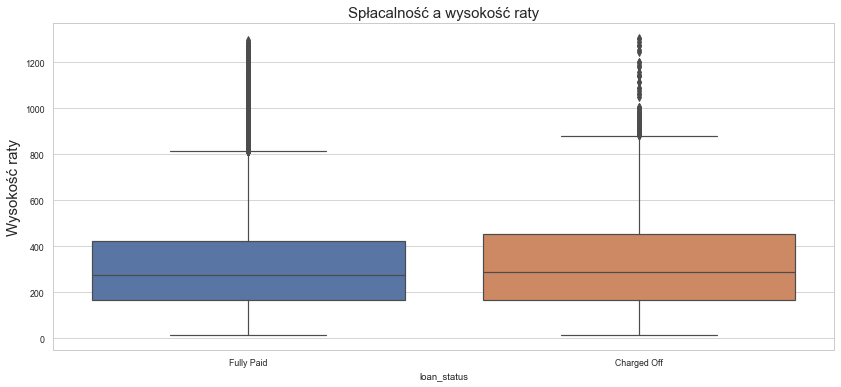

In [160]:
plt.figure(figsize=(14,6))

sns.boxplot(y="installment", x="loan_status", data=df)
plt.title("Spłacalność a wysokość raty", fontsize=15)
plt.ylabel("Wysokość raty", fontsize=15)

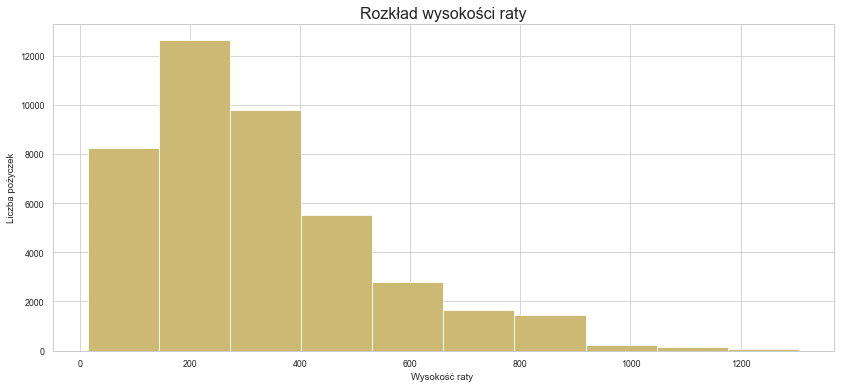

In [161]:
df.installment.hist(figsize=(14,6), color='y')
plt.ylabel('Liczba pożyczek')
plt.xlabel('Wysokość raty ')
plt.title("Rozkład wysokości raty", fontsize=16)
plt.show()

Wysokość raty nie ma wpływu na to czy pożyczka jest spłacana lub nie. 

Średnia wysokośc raty w obu przypadkach jest bardzo podobna.

Najwięcej pożyczek ma ratę w wysokości między 150 a 250 dolarów.

-------------------------------------------------------------------------------------------------------------------

OKRES KREDYTOWANIA

 36 months    31534
 60 months    11001
Name: term, dtype: int64


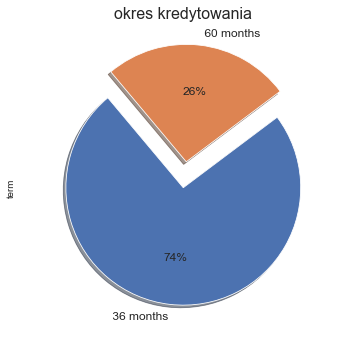

In [162]:
print(df["term"].value_counts())

plt.figure(figsize=(14,6))

df["term"].value_counts().plot.pie(explode=[0,0.2], autopct='%.0f%%', radius=0.9,
                                       shadow=True, 
                                       fontsize=12, startangle=130)

plt.title('okres kredytowania', fontsize=16)
plt.show()

In [163]:
df_cross = pd.crosstab(df['term'], df['loan_status'])
print(df_cross)

loan_status  Charged Off  Fully Paid
term                                
 36 months          3876       27658
 60 months          2555        8446


Text(0.5, 1.0, 'spłacalność pożyczki 60m')

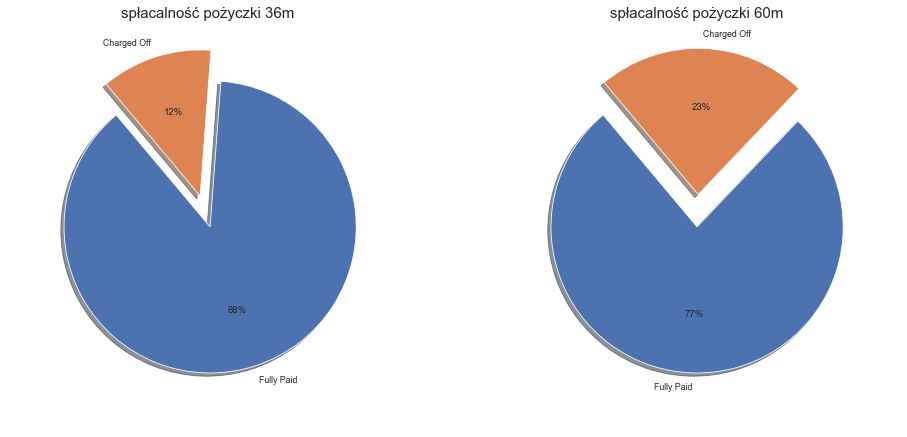

In [164]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
y = np.array([27658, 3876])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność pożyczki 36m ', fontsize=15)

plt.subplot(1,2,2)
y = np.array([8446, 2555])
mylabels = ["Fully Paid", "Charged Off"]

plt.pie(y, labels = mylabels, explode = [0, 0.2], autopct='%.0f%%', radius=0.9, 
                                    shadow = True, 
                                    startangle=130)

plt.title('spłacalność pożyczki 60m', fontsize=15)

Pożyczki z okresem kredytowania 60 miesięcy stanowią 26% wszystkich pożyczek i mają one gorszą spłacalność niż te

udzielone na okres krótszy.

-------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------

3. FEATURE ENGINEERING

Utworzę kilka nowych kolumn z przedziałami, a potem zrobię encoding: 
    
fico_rating, interest_groups, loan_amnt_groups

Kolumny kategoryczne przygotuję do modelowania poprzez encoding

Kolumna grade i subgrade niosą podobne informacje, ale więcej jest w subgrade, dlatego grade usuwam

Dwie kolumny z datami skonwertuje do liczby lat i utworzę nową kolumnę wiek kredytowy - credit_age 

In [165]:
df.dtypes

loan_amnt                 float64
funded_amnt               float64
funded_amnt_inv           float64
term                       object
int_rate                  float64
installment               float64
grade                      object
sub_grade                  object
emp_length                float64
home_ownership             object
annual_inc                float64
verification_status        object
issue_d                    object
loan_status                object
purpose                    object
addr_state                 object
dti                       float64
delinq_2yrs               float64
earliest_cr_line            int64
inq_last_6mths            float64
mths_since_last_delinq    float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
pub_rec_bankruptcies      float64
fico_avg                  float64
last_fico_avg             float64
dtype: object

In [166]:
df.dtypes.value_counts()

float64    19
object      9
int64       1
dtype: int64

In [167]:
df[['grade','sub_grade']]

,grade,sub_grade
0,B,B2
1,C,C4
2,C,C5
3,C,C1
4,B,B5
...,...,...
42531,C,C1
42532,B,B4
42533,B,B3
42534,A,A5


In [168]:
df.drop([('grade')],axis=1,inplace=True)

In [169]:
df['issue_d']

0        Dec-2011
1        Dec-2011
2        Dec-2011
3        Dec-2011
4        Dec-2011
           ...   
42531    Jun-2007
42532    Jun-2007
42533    Jun-2007
42534    Jun-2007
42535    Jun-2007
Name: issue_d, Length: 42535, dtype: object

In [170]:
df['issue_d'] = pd.DatetimeIndex(df['issue_d']).year
df['issue_d']

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
42531    2007
42532    2007
42533    2007
42534    2007
42535    2007
Name: issue_d, Length: 42535, dtype: int64

In [171]:
df['credit_age'] = df['issue_d'] - df['earliest_cr_line']

In [172]:
df['credit_age']

0        26
1        12
2        10
3        15
4        15
         ..
42531     8
42532     8
42533     8
42534     8
42535     8
Name: credit_age, Length: 42535, dtype: int64

In [173]:
df.credit_age.describe()

count    42535.000000
mean        13.647114
std          6.880458
min          0.000000
25%          9.000000
50%         12.000000
75%         17.000000
max         65.000000
Name: credit_age, dtype: float64

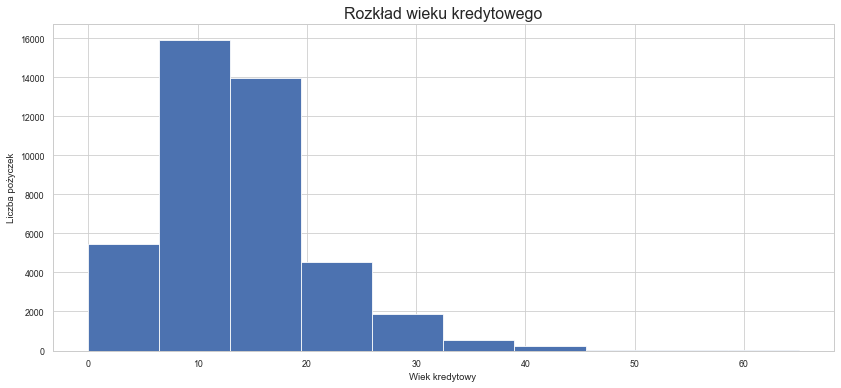

In [174]:
df.credit_age.hist(figsize=(14,6), color='b')
plt.ylabel('Liczba pożyczek')
plt.xlabel('Wiek kredytowy ')
plt.title("Rozkład wieku kredytowego", fontsize=16)
plt.show()

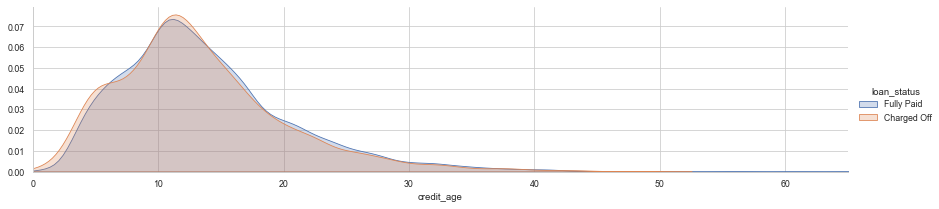

In [175]:
fig = sns.FacetGrid(data=df, hue="loan_status", aspect=4)
fig.map(sns.kdeplot, "credit_age", shade=True)

oldest = df["credit_age"].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

Text(0, 0.5, 'Wiek kredytowy')

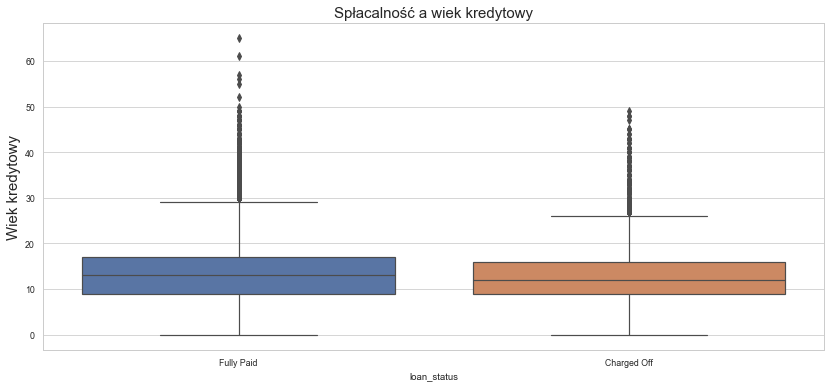

In [176]:
plt.figure(figsize=(14,6))

sns.boxplot(y="credit_age", x="loan_status", data=df)
plt.title("Spłacalność a wiek kredytowy", fontsize=15)
plt.ylabel("Wiek kredytowy", fontsize=15)

FICO RATING

In [177]:
df['fico_rating'] = pd.cut(df['fico_avg'], bins=[0,580,670,740,800,1000], labels=["Poor", "Fair", "Good", "Very_Good", "Exceptional"])

In [178]:
df.fico_rating.value_counts()

Good           27846
Very_Good      10171
Fair            3894
Exceptional      624
Poor               0
Name: fico_rating, dtype: int64

Wiek kredytowy a fico rating

Text(0, 0.5, 'Wiek kredytowy')

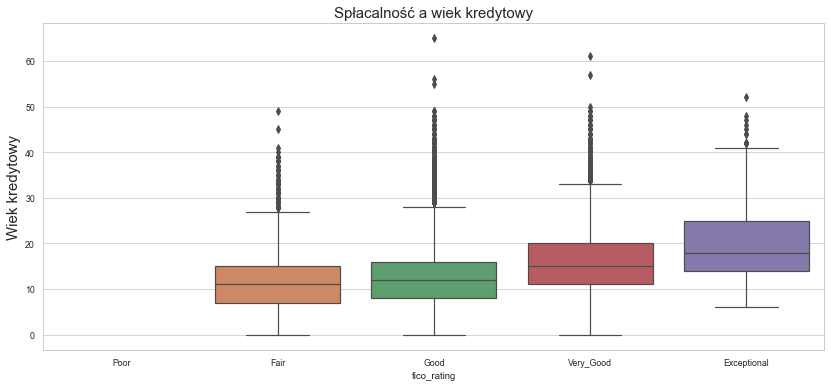

In [179]:
plt.figure(figsize=(14,6))

sns.boxplot(y="credit_age", x="fico_rating", data=df)
plt.title("Spłacalność a wiek kredytowy", fontsize=15)
plt.ylabel("Wiek kredytowy", fontsize=15)

GRUPA OPROCENTOWANIA

In [180]:
df.int_rate.describe()

count    42535.000000
mean        12.165016
std          3.707936
min          5.420000
25%          9.630000
50%         11.990000
75%         14.720000
max         24.590000
Name: int_rate, dtype: float64

In [181]:
df['int_rate_group'] = pd.cut(df['int_rate'], bins=[0,9.63,14.72,25], labels=["Low", "Medium", "High"])

Grupa oprocentowania a fico

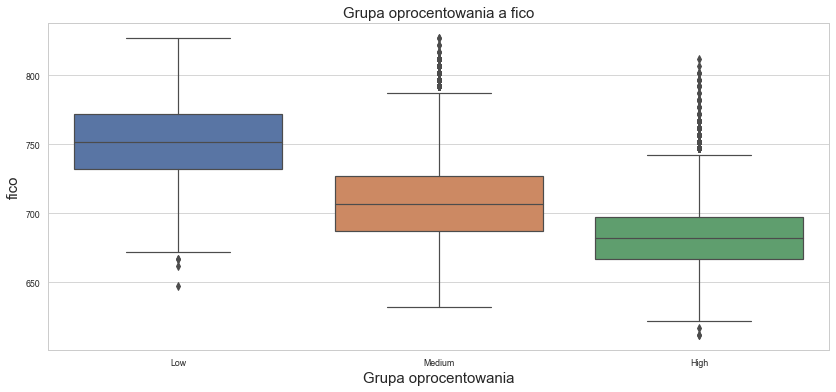

In [182]:
plt.figure(figsize=(14,6))

sns.boxplot(y="fico_avg", x="int_rate_group", data=df)

plt.title("Grupa oprocentowania a fico", fontsize=15)
plt.xlabel("Grupa oprocentowania", fontsize=15)
plt.ylabel("fico", fontsize=15)
plt.show()

Grupa oprocentowania a wysokość raty

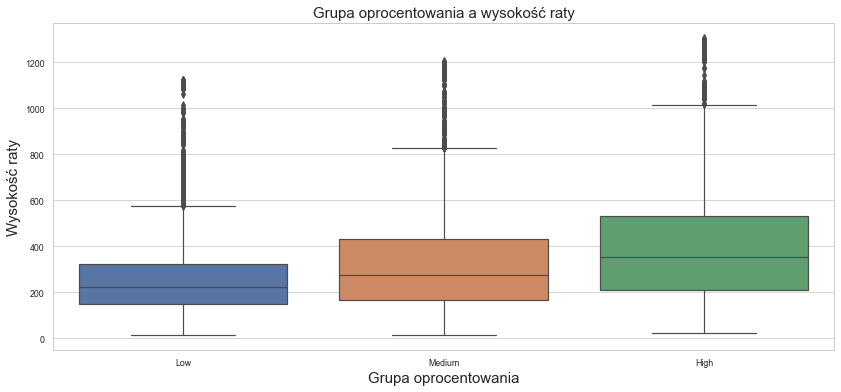

In [183]:
plt.figure(figsize=(14,6))

sns.boxplot(y="installment", x="int_rate_group", data=df)

plt.title("Grupa oprocentowania a wysokość raty", fontsize=15)
plt.xlabel("Grupa oprocentowania", fontsize=15)
plt.ylabel("Wysokość raty", fontsize=15)
plt.show()

W grupie z najniższym oprocentowaniem średnia wysokość raty jest najniższa, a z najwyższym, najwyższa.

Grupa oprocentowania a wysokość pożyczki

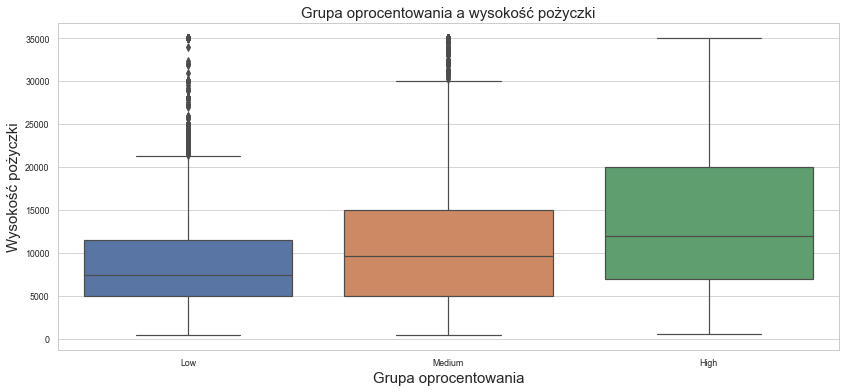

In [184]:
plt.figure(figsize=(14,6))

sns.boxplot(y="loan_amnt", x="int_rate_group", data=df)

plt.title("Grupa oprocentowania a wysokość pożyczki", fontsize=15)
plt.xlabel("Grupa oprocentowania", fontsize=15)
plt.ylabel("Wysokość pożyczki", fontsize=15)
plt.show()

GRUPA WYSOKOŚCI POŻYCZKI

In [185]:
df.loan_amnt.describe()

count    42535.000000
mean     11089.722581
std       7410.938391
min        500.000000
25%       5200.000000
50%       9700.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [186]:
df['loan_amnt_group'] = pd.cut(df['loan_amnt'], bins=[0,5000,10000,15000,20000,25000,50000], labels=["Very Low", "Low", "Medium", "Medium High", "High", "Very High"])

Grupa wyskokości pożyczki a wiek kredytowy

<function matplotlib.pyplot.show(close=None, block=None)>

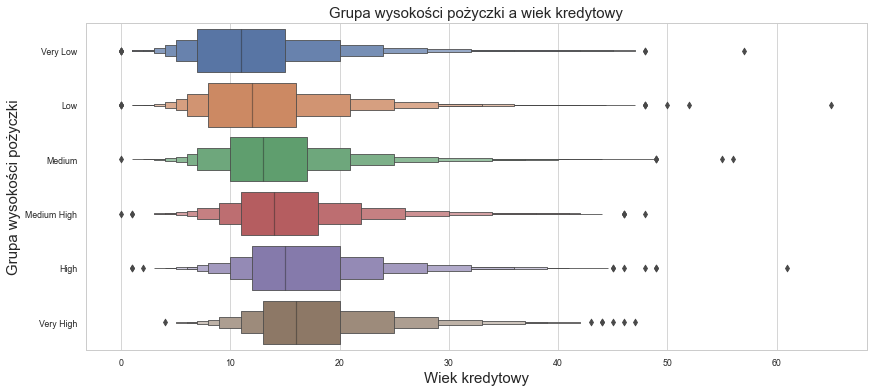

In [187]:
plt.figure(figsize=(14,6))

sns.boxenplot(x="credit_age", y="loan_amnt_group", data=df)
plt.title("Grupa wysokości pożyczki a wiek kredytowy", fontsize=15)
plt.ylabel("Grupa wysokości pożyczki", fontsize=15)
plt.xlabel("Wiek kredytowy", fontsize=15)
plt.show

KOLUMNY DO ENCODOWANIA

In [188]:
df.select_dtypes('object')

,term,sub_grade,home_ownership,verification_status,loan_status,purpose,addr_state
0,36 months,B2,RENT,Verified,Fully Paid,credit_card,AZ
1,60 months,C4,RENT,Source Verified,Charged Off,car,GA
2,36 months,C5,RENT,Not Verified,Fully Paid,small_business,IL
3,36 months,C1,RENT,Source Verified,Fully Paid,other,CA
4,60 months,B5,RENT,Source Verified,Fully Paid,other,OR
...,...,...,...,...,...,...,...
42531,36 months,C1,RENT,Not Verified,Fully Paid,other,NY
42532,36 months,B4,RENT,Not Verified,Fully Paid,other,MA
42533,36 months,B3,RENT,Not Verified,Fully Paid,other,NY
42534,36 months,A5,NONE,Not Verified,Fully Paid,other,NY


In [189]:
df.select_dtypes('category')

,fico_rating,int_rate_group,loan_amnt_group
0,Good,Medium,Very Low
1,Very_Good,High,Very Low
2,Good,High,Very Low
3,Good,Medium,Low
4,Good,Medium,Very Low
...,...,...,...
42531,Good,Medium,Very Low
42532,Good,Medium,Very Low
42533,Good,Low,Very Low
42534,Very_Good,Low,Low


OUTLIERS

In [190]:
df_outliers = df.select_dtypes(exclude=['object', 'category']).copy()
df_outliers.T

,0,1,2,3,4,5,6,7,8,9,...,42526,42527,42528,42529,42530,42531,42532,42533,42534,42535
loan_amnt,5000.00,2500.00,2400.00,10000.00,3000.00,5000.00,7000.00,3000.00,5600.00,5375.00,...,10500.00,3000.00,3000.00,2000.00,6500.00,3500.00,1000.00,2525.00,6500.00,5000.00
funded_amnt,5000.00,2500.00,2400.00,10000.00,3000.00,5000.00,7000.00,3000.00,5600.00,5375.00,...,10500.00,3000.00,3000.00,2000.00,6500.00,3500.00,1000.00,2525.00,6500.00,5000.00
funded_amnt_inv,4975.00,2500.00,2400.00,10000.00,3000.00,5000.00,7000.00,3000.00,5600.00,5350.00,...,275.00,125.00,0.00,225.00,0.00,225.00,0.00,225.00,0.00,0.00
int_rate,10.65,15.27,15.96,13.49,12.69,7.90,15.96,18.64,21.28,12.69,...,11.22,9.01,9.33,9.96,9.64,10.28,9.64,9.33,8.38,7.75
installment,162.87,59.83,84.33,339.31,67.79,156.46,170.08,109.43,152.39,121.45,...,344.87,95.42,95.86,64.50,208.66,113.39,32.11,80.69,204.84,156.11
emp_length,10.00,0.00,10.00,10.00,1.00,3.00,8.00,9.00,4.00,0.00,...,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00
annual_inc,24000.00,30000.00,12252.00,49200.00,80000.00,36000.00,47004.00,48000.00,40000.00,15000.00,...,60000.00,35000.00,20000.00,6000.00,20000.00,180000.00,12000.00,110000.00,60000.00,70000.00
issue_d,2011.00,2011.00,2011.00,2011.00,2011.00,2011.00,2011.00,2011.00,2011.00,2011.00,...,2007.00,2007.00,2007.00,2007.00,2007.00,2007.00,2007.00,2007.00,2007.00,2007.00
dti,27.65,1.00,8.72,20.00,17.94,11.20,23.51,5.35,5.55,18.08,...,19.50,10.00,10.00,10.00,10.00,10.00,10.00,10.00,4.00,8.81
delinq_2yrs,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [191]:
Q1 = df_outliers.quantile(0.25)
Q3 = df_outliers.quantile(0.75)
IQR = Q3 - Q1
median = df_outliers.quantile(0.50)

df_outliers_amnt = pd.DataFrame({'Q1':Q1, 'Q3' :Q3, 'IQR': IQR, 'median': median, 'lower': (Q1 - 1.5*IQR), 'upper': (Q3 + 1.5*IQR),
                                 'number of outliers': ((df_outliers < (Q1 - 1.5*IQR)) | (df_outliers > (Q3 + 1.5*IQR))).sum()
                                })

df_outliers_amnt

,Q1,Q3,IQR,median,lower,upper,number of outliers
loan_amnt,5200.00,15000.00,9800.00,9700.00,-9500.000,29700.000,1218
funded_amnt,5000.00,15000.00,10000.00,9600.00,-10000.000,30000.000,691
funded_amnt_inv,4950.00,14000.00,9050.00,8500.00,-8625.000,27575.000,1154
int_rate,9.63,14.72,5.09,11.99,1.995,22.355,94
installment,165.52,428.18,262.66,277.69,-228.470,822.170,1393
emp_length,2.00,9.00,7.00,4.00,-8.500,19.500,0
annual_inc,40000.00,82500.00,42500.00,59000.00,-23750.000,146250.000,2032
issue_d,2010.00,2011.00,1.00,2011.00,2008.500,2012.500,2996
dti,8.20,18.68,10.48,13.47,-7.520,34.400,0
delinq_2yrs,0.00,0.00,0.00,0.00,0.000,0.000,4735


In [192]:
df_outliers.drop(['delinq_2yrs', 'pub_rec', 'pub_rec_bankruptcies'], axis = 1, inplace = True)

In [193]:
df_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,42535.0,11089.722581,7410.938391,500.00,5200.00,9700.00,15000.00,35000.00
funded_amnt,42535.0,10821.585753,7146.914675,500.00,5000.00,9600.00,15000.00,35000.00
funded_amnt_inv,42535.0,10139.938785,7131.598014,0.00,4950.00,8500.00,14000.00,35000.00
int_rate,42535.0,12.165016,3.707936,5.42,9.63,11.99,14.72,24.59
installment,42535.0,322.623063,208.927216,15.67,165.52,277.69,428.18,1305.19
emp_length,42535.0,5.055813,3.613600,0.00,2.00,4.00,9.00,10.00
annual_inc,42535.0,69135.697217,64093.396996,1896.00,40000.00,59000.00,82500.00,6000000.00
issue_d,42535.0,2010.231456,0.966383,2007.00,2010.00,2011.00,2011.00,2011.00
dti,42535.0,13.373043,6.726315,0.00,8.20,13.47,18.68,29.99
earliest_cr_line,42535.0,1996.584342,6.838072,1946.00,1993.00,1998.00,2001.00,2008.00


zamieniam outliersy na mediany

In [194]:
for col_name in df_outliers.columns[:-1]:
    q1 = df_outliers[col_name].quantile(0.25)
    q3 = df_outliers[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    df_outliers.loc[(df_outliers[col_name] < low) | (df_outliers[col_name] > high), col_name] = df_outliers[col_name].median()

KORELACJA

KORELACJA WSZYSTKICH CECH

Najpierw robię encoding targetu

In [195]:
le = LabelEncoder()
df['loan_status'] = le.fit_transform(df['loan_status'])

In [196]:
corr = df.corr()
corr

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,issue_d,loan_status,dti,...,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,fico_avg,last_fico_avg,credit_age
loan_amnt,1.000000,0.981746,0.929600,0.292346,0.930869,0.139773,0.276125,0.142493,-0.042582,0.065112,...,0.008160,0.171373,-0.051460,0.254293,0.065231,0.256958,-0.035277,0.133232,0.080111,0.209728
funded_amnt,0.981746,1.000000,0.947527,0.295154,0.956522,0.139378,0.272070,0.152112,-0.039602,0.064821,...,0.008930,0.169539,-0.052447,0.250313,0.068865,0.251163,-0.036591,0.125637,0.080217,0.204865
funded_amnt_inv,0.929600,0.947527,1.000000,0.279995,0.890151,0.156946,0.252330,0.309730,-0.009896,0.071073,...,0.052927,0.150177,-0.055497,0.212346,0.069516,0.240875,-0.037468,0.144942,0.094931,0.211097
int_rate,0.292346,0.295154,0.279995,1.000000,0.271433,-0.011585,0.054377,0.006153,-0.200598,0.119607,...,-0.011536,0.021721,0.100456,0.081883,0.456247,-0.031538,0.084944,-0.702587,-0.282394,-0.114161
installment,0.930869,0.956522,0.890151,0.271433,1.000000,0.109638,0.278342,0.072136,-0.021094,0.054948,...,-0.000512,0.170247,-0.045678,0.264837,0.094486,0.233939,-0.032499,0.064362,0.075866,0.178146
emp_length,0.139773,0.139378,0.156946,-0.011585,0.109638,1.000000,0.099083,0.151854,-0.019234,0.054308,...,0.045230,0.084875,0.066510,0.115684,0.004105,0.198764,0.069871,0.098385,0.022062,0.311222
annual_inc,0.276125,0.272070,0.252330,0.054377,0.278342,0.099083,1.000000,0.012640,0.037988,-0.116519,...,0.001196,0.166544,-0.016344,0.283595,0.021377,0.246085,-0.014653,0.051989,0.065137,0.189693
issue_d,0.142493,0.152112,0.309730,0.006153,0.072136,0.151854,0.012640,1.000000,0.025840,0.074841,...,0.134174,-0.007952,-0.019825,-0.052553,0.041302,0.058241,0.006514,0.100920,0.037954,0.113951
loan_status,-0.042582,-0.039602,-0.009896,-0.200598,-0.021094,-0.019234,0.037988,0.025840,1.000000,-0.042198,...,0.006216,0.006389,-0.053770,-0.017186,-0.095320,0.021093,-0.050607,0.141917,0.440511,0.023413
dti,0.065112,0.064821,0.071073,0.119607,0.054948,0.054308,-0.116519,0.074841,-0.042198,1.000000,...,0.036304,0.292089,-0.002718,0.190727,0.278660,0.241313,0.010149,-0.191153,-0.036380,0.065060


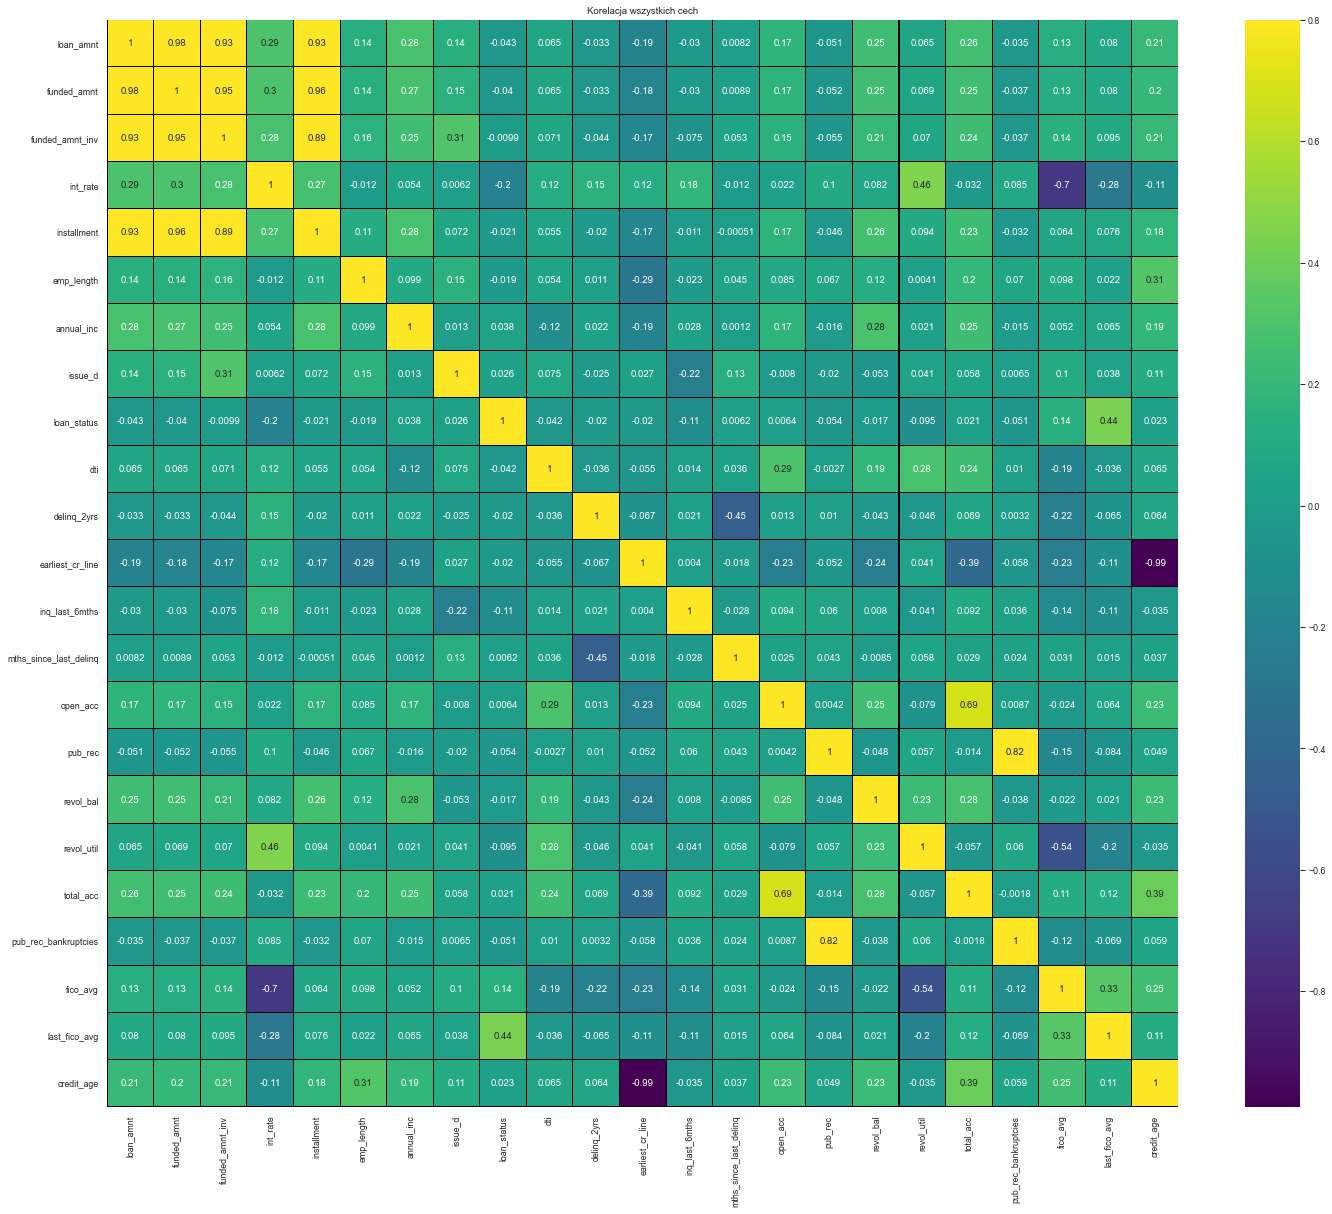

In [197]:
plt.figure(figsize=(24,20))
sns.heatmap(corr, cmap='viridis', annot=True, vmax=.8, linewidths=0.01, linecolor='black')
plt.title('Korelacja wszystkich cech')
plt.show()

usunę jeszcze dwie kolumny : funded_amnt i funded_amnt_inv, które są bardzo mocno skorelowane z loan_amnt

In [198]:
df.drop(['funded_amnt', 'funded_amnt_inv'], axis = 1, inplace = True)

KORELACJA WYBRANYCH CECH

In [199]:
df1=df[['annual_inc', 'installment', 'int_rate', 'fico_avg', 'last_fico_avg', 'loan_amnt', 'revol_bal', 'open_acc', 'total_acc', 'loan_status']]

In [200]:
df1

,annual_inc,installment,int_rate,fico_avg,last_fico_avg,loan_amnt,revol_bal,open_acc,total_acc,loan_status
0,24000.0,162.87,10.65,737.0,737.0,5000.0,13648.0,3.0,9.0,1
1,30000.0,59.83,15.27,742.0,249.5,2500.0,1687.0,3.0,4.0,0
2,12252.0,84.33,15.96,737.0,737.0,2400.0,2956.0,2.0,10.0,1
3,49200.0,339.31,13.49,692.0,602.0,10000.0,5598.0,10.0,37.0,1
4,80000.0,67.79,12.69,697.0,682.0,3000.0,27783.0,15.0,38.0,1
...,...,...,...,...,...,...,...,...,...,...
42531,180000.0,113.39,10.28,687.0,817.0,3500.0,0.0,33.0,20.0,1
42532,12000.0,32.11,9.64,697.0,782.0,1000.0,0.0,33.0,20.0,1
42533,110000.0,80.69,9.33,712.0,712.0,2525.0,0.0,33.0,20.0,1
42534,60000.0,204.84,8.38,742.0,722.0,6500.0,0.0,33.0,20.0,1


In [201]:
corr1 = df1.corr()
corr1  

,annual_inc,installment,int_rate,fico_avg,last_fico_avg,loan_amnt,revol_bal,open_acc,total_acc,loan_status
annual_inc,1.000000,0.278342,0.054377,0.051989,0.065137,0.276125,0.283595,0.166544,0.246085,0.037988
installment,0.278342,1.000000,0.271433,0.064362,0.075866,0.930869,0.264837,0.170247,0.233939,-0.021094
int_rate,0.054377,0.271433,1.000000,-0.702587,-0.282394,0.292346,0.081883,0.021721,-0.031538,-0.200598
fico_avg,0.051989,0.064362,-0.702587,1.000000,0.328915,0.133232,-0.022011,-0.024329,0.110587,0.141917
last_fico_avg,0.065137,0.075866,-0.282394,0.328915,1.000000,0.080111,0.021390,0.064252,0.115398,0.440511
loan_amnt,0.276125,0.930869,0.292346,0.133232,0.080111,1.000000,0.254293,0.171373,0.256958,-0.042582
revol_bal,0.283595,0.264837,0.081883,-0.022011,0.021390,0.254293,1.000000,0.253027,0.275417,-0.017186
open_acc,0.166544,0.170247,0.021721,-0.024329,0.064252,0.171373,0.253027,1.000000,0.686052,0.006389
total_acc,0.246085,0.233939,-0.031538,0.110587,0.115398,0.256958,0.275417,0.686052,1.000000,0.021093
loan_status,0.037988,-0.021094,-0.200598,0.141917,0.440511,-0.042582,-0.017186,0.006389,0.021093,1.000000


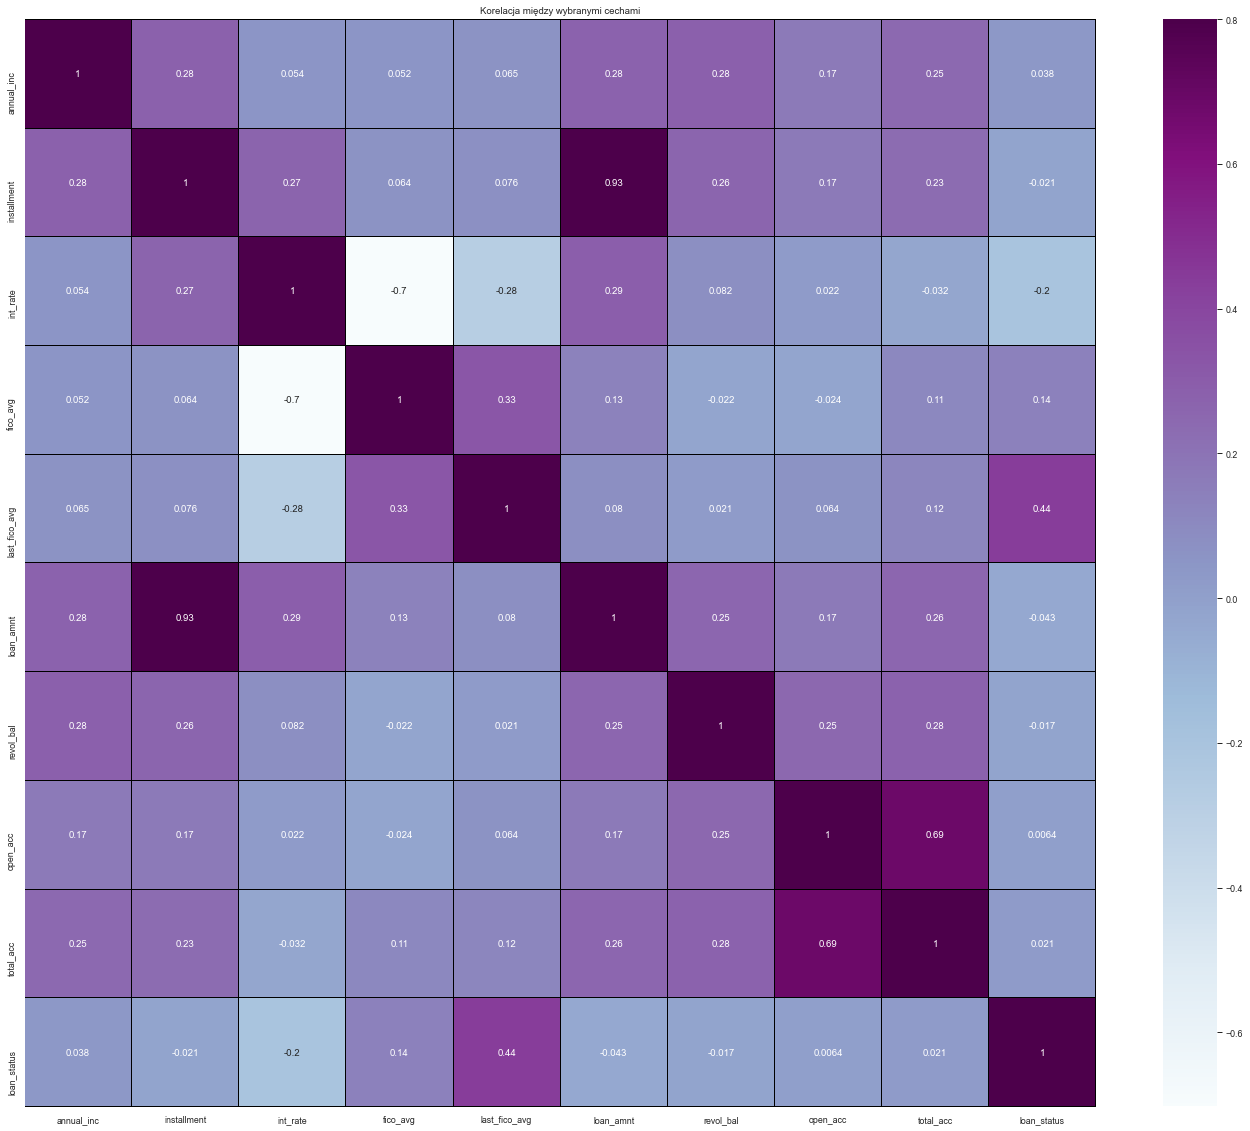

In [202]:
plt.figure(figsize=(24,20))
sns.heatmap(corr1, cmap='BuPu', annot=True, vmax=.8, linewidths=0.01, linecolor='black')
plt.title('Korelacja między wybranymi cechami')
plt.show()

Encodowanie zmiennych kategorycznych porządkowych: sub_grade, term, fico_rating, int_rate_group, loan_amnt_group

In [203]:
enc = OrdinalEncoder()
df[['sub_grade', 'term', 'fico_rating', 'int_rate_group', 'loan_amnt_group']] = enc.fit_transform(df[['sub_grade', 'term', 'fico_rating', 'int_rate_group', 'loan_amnt_group']])
df

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,fico_avg,last_fico_avg,credit_age,fico_rating,int_rate_group,loan_amnt_group
0,5000.0,0.0,10.65,162.87,6.0,10.0,RENT,24000.0,Verified,2011,...,13648.0,83.7,9.0,0.0,737.0,737.0,26,2.0,2.0,5.0
1,2500.0,1.0,15.27,59.83,13.0,0.0,RENT,30000.0,Source Verified,2011,...,1687.0,9.4,4.0,0.0,742.0,249.5,12,3.0,0.0,5.0
2,2400.0,0.0,15.96,84.33,14.0,10.0,RENT,12252.0,Not Verified,2011,...,2956.0,98.5,10.0,0.0,737.0,737.0,10,2.0,0.0,5.0
3,10000.0,0.0,13.49,339.31,10.0,10.0,RENT,49200.0,Source Verified,2011,...,5598.0,21.0,37.0,0.0,692.0,602.0,15,2.0,2.0,1.0
4,3000.0,1.0,12.69,67.79,9.0,1.0,RENT,80000.0,Source Verified,2011,...,27783.0,53.9,38.0,0.0,697.0,682.0,15,2.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42531,3500.0,0.0,10.28,113.39,10.0,0.0,RENT,180000.0,Not Verified,2007,...,0.0,49.7,20.0,0.0,687.0,817.0,8,2.0,2.0,5.0
42532,1000.0,0.0,9.64,32.11,8.0,0.0,RENT,12000.0,Not Verified,2007,...,0.0,49.7,20.0,0.0,697.0,782.0,8,2.0,2.0,5.0
42533,2525.0,0.0,9.33,80.69,7.0,0.0,RENT,110000.0,Not Verified,2007,...,0.0,49.7,20.0,0.0,712.0,712.0,8,2.0,1.0,5.0
42534,6500.0,0.0,8.38,204.84,4.0,0.0,NONE,60000.0,Not Verified,2007,...,0.0,49.7,20.0,0.0,742.0,722.0,8,3.0,1.0,1.0


Encodowanie pozostałych zmiennych kategorycznych

In [204]:
df_dummies = pd.get_dummies(df)
df_dummies

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,loan_status,dti,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,5000.0,0.0,10.65,162.87,6.0,10.0,24000.0,2011,1,27.65,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,1.0,15.27,59.83,13.0,0.0,30000.0,2011,0,1.00,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,0.0,15.96,84.33,14.0,10.0,12252.0,2011,1,8.72,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,0.0,13.49,339.31,10.0,10.0,49200.0,2011,1,20.00,...,0,0,0,0,0,0,0,0,0,0
4,3000.0,1.0,12.69,67.79,9.0,1.0,80000.0,2011,1,17.94,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42531,3500.0,0.0,10.28,113.39,10.0,0.0,180000.0,2007,1,10.00,...,0,0,0,0,0,0,0,0,0,0
42532,1000.0,0.0,9.64,32.11,8.0,0.0,12000.0,2007,1,10.00,...,0,0,0,0,0,0,0,0,0,0
42533,2525.0,0.0,9.33,80.69,7.0,0.0,110000.0,2007,1,10.00,...,0,0,0,0,0,0,0,0,0,0
42534,6500.0,0.0,8.38,204.84,4.0,0.0,60000.0,2007,1,4.00,...,0,0,0,0,0,0,0,0,0,0


In [205]:
df_outliers

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,issue_d,dti,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,fico_avg,last_fico_avg,credit_age
0,5000.0,5000.0,4975.0,10.65,162.87,10.0,24000.0,2011.0,27.65,1985.0,1.0,33.0,3.0,13648.0,83.7,9.0,737.0,737.0,26
1,2500.0,2500.0,2500.0,15.27,59.83,0.0,30000.0,2011.0,1.00,1999.0,5.0,33.0,3.0,1687.0,9.4,4.0,742.0,697.0,12
2,2400.0,2400.0,2400.0,15.96,84.33,10.0,12252.0,2011.0,8.72,2001.0,2.0,33.0,2.0,2956.0,98.5,10.0,737.0,737.0,10
3,10000.0,10000.0,10000.0,13.49,339.31,10.0,49200.0,2011.0,20.00,1996.0,1.0,33.0,10.0,5598.0,21.0,37.0,692.0,602.0,15
4,3000.0,3000.0,3000.0,12.69,67.79,1.0,80000.0,2011.0,17.94,1996.0,0.0,33.0,15.0,27783.0,53.9,38.0,697.0,682.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42531,3500.0,3500.0,225.0,10.28,113.39,0.0,59000.0,2011.0,10.00,1999.0,1.0,33.0,9.0,0.0,49.7,20.0,687.0,817.0,8
42532,1000.0,1000.0,0.0,9.64,32.11,0.0,12000.0,2011.0,10.00,1999.0,1.0,33.0,9.0,0.0,49.7,20.0,697.0,782.0,8
42533,2525.0,2525.0,225.0,9.33,80.69,0.0,110000.0,2011.0,10.00,1999.0,1.0,33.0,9.0,0.0,49.7,20.0,712.0,712.0,8
42534,6500.0,6500.0,0.0,8.38,204.84,0.0,60000.0,2011.0,4.00,1999.0,1.0,33.0,9.0,0.0,49.7,20.0,742.0,722.0,8


In [206]:
df1

,annual_inc,installment,int_rate,fico_avg,last_fico_avg,loan_amnt,revol_bal,open_acc,total_acc,loan_status
0,24000.0,162.87,10.65,737.0,737.0,5000.0,13648.0,3.0,9.0,1
1,30000.0,59.83,15.27,742.0,249.5,2500.0,1687.0,3.0,4.0,0
2,12252.0,84.33,15.96,737.0,737.0,2400.0,2956.0,2.0,10.0,1
3,49200.0,339.31,13.49,692.0,602.0,10000.0,5598.0,10.0,37.0,1
4,80000.0,67.79,12.69,697.0,682.0,3000.0,27783.0,15.0,38.0,1
...,...,...,...,...,...,...,...,...,...,...
42531,180000.0,113.39,10.28,687.0,817.0,3500.0,0.0,33.0,20.0,1
42532,12000.0,32.11,9.64,697.0,782.0,1000.0,0.0,33.0,20.0,1
42533,110000.0,80.69,9.33,712.0,712.0,2525.0,0.0,33.0,20.0,1
42534,60000.0,204.84,8.38,742.0,722.0,6500.0,0.0,33.0,20.0,1


Eksport plików

In [207]:
df.to_csv("df.csv")

In [208]:
df_outliers.to_csv("df_outliers.csv")

In [209]:
df_dummies.to_csv("df_dummies.csv")

In [210]:
df1.to_csv("df1.csv")

In [211]:
df.shape

(42535, 30)

In [212]:
df1.shape

(42535, 10)

In [213]:
df_dummies.shape

(42535, 98)

In [214]:
df_outliers.shape

(42535, 19)